··························································································································································································································································
En esta práctica se nos ha propuesto hacer una clasificación mediante aprendizaje automático no supervisado de los tipos de estrellas. Para ello, se han seguido los siguientes pasos:<br>
1) Método K-Means personalizado.<br>
2) Para poder dibujar o ver el problema y como se clasifican los distintos cluster, hacer transformación de componentes con PCA.(¡Escalando datos y comprobando variabilidad!)<br>
3) Implementación de distintos modelos para el problema (JERARQUICO, KMEANS, DBSCAN, ETC).<br>
4) Generar boxplot con uno de los modelos, y ver resultados finales y compararlos con la tabla de tipos de estrellas.<br>
5) Hacer la transformación de las variables categóricas con One-Hot-Encoding y comparar resultados ¿Es útil para el problema planteado?
····················································································································································································································································


----------------------------------------------------------------------------------------------------------------
## IMPORTS
----------------------------------------------------------------------------------------------------------------

In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import time
import seaborn as sns
import pandas as pd
from sklearn.datasets import make_blobs

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import style
style.use('ggplot') or plt.style.use('ggplot')

# Preprocesado y modelado
# ==============================================================================

from sklearn.cluster import KMeans as KMeans_sklearn
from sklearn.preprocessing import scale
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import OneHotEncoder
from sklearn.mixture import GaussianMixture
#from sklearn_extra.cluster import KMedoids

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

----------------------------------------------------------------------------------------------------------------
## IMPLEMENTACIÓN K-MEANS
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a realizar nuestra propia implementación de K-Means. Nuestra implementación de K-Means tiene los siguientes parámetros:<br>
-n_clusters: determina el número 𝐾 de clusters (grupos) que se van a generar.<br>
-max_iter: número máximo de iteraciones permitidas.<br>
-tol: Distancia entre los centroides antiguos y los nuevos, en el que el algoritmo se detiene, asumiendo que ha alcanzado una solución suficientemente buena.
····················································································································································································································································

In [2]:
class KMeansP:
    def __init__(self, n_clusters=3, max_iter=100, tol=1e-4):
         # Inicialización de los parámetros 
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol

    def _init_centroids(self, X):
        # Método para inicializar los centroides
        centroids = [X[np.random.randint(X.shape[0])]]
        for _ in range(1, self.n_clusters):
            dist_sq = np.array([min([np.inner(c-x,c-x) for c in centroids]) for x in X])
            probs = dist_sq/dist_sq.sum()
            cumulative_probs = probs.cumsum()
            r = np.random.rand()
            
            for j, p in enumerate(cumulative_probs):
                if r < p:
                    i = j
                    break
            
            centroids.append(X[i])

        return np.array(centroids)

    def fit(self, X):
        # Método para ajustar el modelo a los datos
        centroids = self._init_centroids(X)

        for _ in range(self.max_iter):
            # Se calculan las distancias de cada punto a los centroides
            distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1)
            # Se asigna cada punto al centroide más cercano
            labels = np.argmin(distances, axis=-1)
            #Volver a calcular nuevos centroides.
            new_centroids = np.array([X[labels == i].mean(axis=0) if len(X[labels == i]) else centroids[i] for i in range(self.n_clusters)])

            if np.linalg.norm(new_centroids - centroids) < self.tol:
                break

            centroids = new_centroids

        self.centroids = centroids
        self.labels_ = np.argmin(np.linalg.norm(X[:, np.newaxis] - centroids, axis=-1), axis=-1)
        return self

    def predict(self, X):
        return np.argmin(np.linalg.norm(X[:, np.newaxis] - self.centroids, axis=-1), axis=-1)

    def get_centroids(self):
        return self.centroids
    

····················································································································································································································································
Para poder ver si nuestra implementación de K-Means es correcta y compararla con la de sklearn vamos a generar datos de prueba con make_blobs y ver los resultados en dos gráficas una con la de sklearn y otra con nuestra implementación y poder comparar ambos resultados.
····················································································································································································································································

Tiempo de ejecución de nuestro KMeans: 0.004126071929931641
Tiempo de ejecución de KMeans sklearn: 0.051839590072631836
Centroides personalizados:
 [[-1.37324398  7.75368871]
 [ 1.98726097  0.90144281]
 [-0.33514647  3.62624134]]
Centroides scikit-learn:
 [[-0.33514647  3.62624134]
 [-1.37324398  7.75368871]
 [ 1.98726097  0.90144281]]


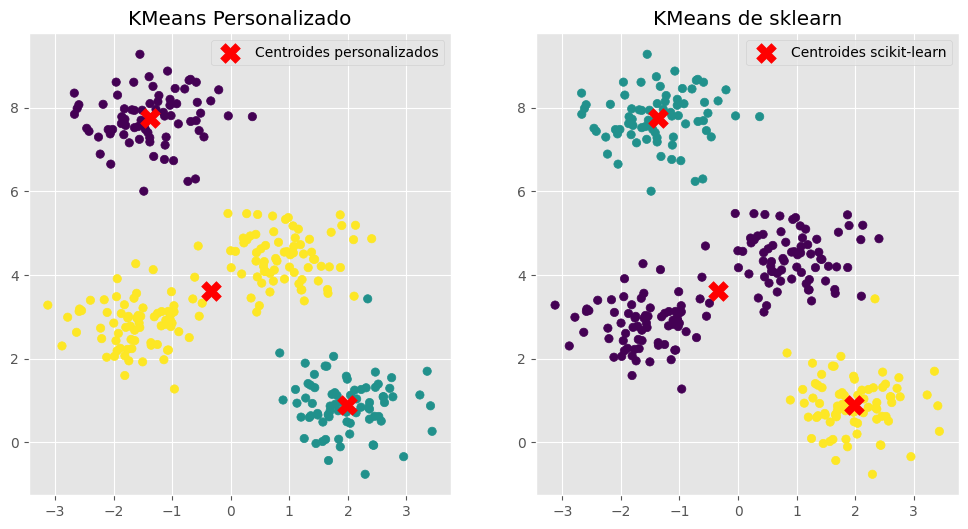

In [3]:
# Generar datos de prueba con make_blobs
X, y = make_blobs(
    n_samples    = 300,
    n_features   = 2,
    centers      = 4,
    cluster_std  = 0.60,
    shuffle      = True,
    random_state = 0
)

# Inicializar y ajustar el modelo de KMeans personalizado
tiempoKmeans = time.time()
kmeans_custom = KMeansP(n_clusters=3)
kmeans_custom.fit(X)
labels_custom = kmeans_custom.predict(X)
centroids_custom = kmeans_custom.centroids
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de nuestro KMeans:", tiempo_ejecucion)

# Inicializar y ajustar el modelo de KMeans de scikit-learn
tiempoKmeans = time.time()
kmeans_sklearn = KMeans_sklearn(n_clusters=3)
kmeans_sklearn.fit(X)
labels_sklearn = kmeans_sklearn.predict(X)
centroids_sklearn = kmeans_sklearn.cluster_centers_
tiempo_ejecucion = time.time()-tiempoKmeans
print("Tiempo de ejecución de KMeans sklearn:", tiempo_ejecucion)
# Comparar los resultados
print("Centroides personalizados:\n", centroids_custom)
print("Centroides scikit-learn:\n", centroids_sklearn)

# Gráfico de los resultados
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.scatter(X[:, 0], X[:, 1], c=labels_custom, cmap='viridis')
plt.scatter(centroids_custom[:, 0], centroids_custom[:, 1], marker='X', s=200, c='red', label='Centroides personalizados')
plt.title('KMeans Personalizado')
plt.legend()

plt.subplot(1, 2, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels_sklearn, cmap='viridis')
plt.scatter(centroids_sklearn[:, 0], centroids_sklearn[:, 1], marker='X', s=200, c='red', label='Centroides scikit-learn')
plt.title('KMeans de sklearn')
plt.legend()

#Mostrar gráficas
plt.show()

····················································································································································································································································
Nuestra implementación de sklearn proporciona las mismas divisiones de cluster que la implementación de Kmeans de sklearn, incluso nuestra implementación es más rápida esto puede ser debido a que sklearn utiliza más parámetros y es un modelo más complejo que necesita algo más de tiempo.
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CARGAR LOS DATOS 
----------------------------------------------------------------------------------------------------------------

In [4]:
# Cargar los datos del csv
import pandas as pd
# Archivo CSV a cargar
archivo = "Stars2.csv"
# Cargamos el archivo y lo mostramos por pantalla.
print(pd.read_csv(archivo))
data_set = pd.read_csv(archivo)  
#Mostrar por encima los datos del csv.
data_set.head()


     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12    Red              M
1           3042       0.000500     0.1542  16.60    Red              M
2           2600       0.000300     0.1020  18.70    Red              M
3           2800       0.000200     0.1600  16.65    Red              M
4           1939       0.000138     0.1030  20.06    Red              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93   Blue              O
236        30839  834042.000000  1194.0000 -10.63   Blue              O
237         8829  537493.000000  1423.0000 -10.73  White              A
238         9235  404940.000000  1112.0000 -11.23  White              A
239        37882  294903.000000  1783.0000  -7.80   Blue              O

[240 rows x 6 columns]


,Temperature,L,R,A_M,Color,Spectral_Class
0,3068,0.002400,0.1700,16.12,Red,M
1,3042,0.000500,0.1542,16.60,Red,M
2,2600,0.000300,0.1020,18.70,Red,M
3,2800,0.000200,0.1600,16.65,Red,M
4,1939,0.000138,0.1030,20.06,Red,M


····················································································································································································································································
Vamos a comprobar que no hay ningún valor nulo y ver los tipos de los datos a anlizar.
····················································································································································································································································

In [5]:
print('The types of the attributes are:')
print('================================')
data_set.info()

print('How many missing values per attribute:')
print('======================================')
print(data_set.isnull().sum())

The types of the attributes are:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Temperature     240 non-null    int64  
 1   L               240 non-null    float64
 2   R               240 non-null    float64
 3   A_M             240 non-null    float64
 4   Color           240 non-null    object 
 5   Spectral_Class  240 non-null    object 
dtypes: float64(3), int64(1), object(2)
memory usage: 11.4+ KB
How many missing values per attribute:
Temperature       0
L                 0
R                 0
A_M               0
Color             0
Spectral_Class    0
dtype: int64


····················································································································································································································································
Hemos comprobado que hay 4 atributos con valores numéricos y los otros dos son de tipo categórico. No hay ningún dato nulo en nuestro conjunto de datos. Tenemos los siguientes atributos:<br>
-Temperature: Temperatura promedio de la superficie en grados K.<br>
-L: Luminosidad comparada con la del Sol.<br>
-R: Radio comparado con la del Sol.<br>
-A_M: Magnitud absoluta (brillo aparente de la estrella si estuviera a 10 parsec de distancia).<br>
-Color: Color principal del espectro. Los colores proporciona información sobre su temperatura superficial y, por lo tanto, sobre su luminosidad, tamaño y otras propiedades físicas. Estrellas más calientes suelen ser azulen y las más frías rojas.(Asoociado a la clase espectral(O---> SUELEN AZULES y M---> SUELEN ROJAS))<br>
-Spectral_Class: Clasificación espectral: es un valor que identifica la presencia elementos químicos en el espectro de la estrella. Es una secuencia (O, B, A, F, G, K, M) que se asocia a las estrellas desde las más calientes O, hasta las más frías M.<br>
····················································································································································································································································

----------------------------------------------------------------------------------------------------------------
## CODIFICACIÓN VARIABLES CATEGÓRICAS A ORDINALES
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Vamos a transformar los atributos categóricos a ordinales, para que se conserve el orden natural de las clases. Por ejemplo, en las clases espectrales O es el más caliente y M, es la más fría. Al asignar números a estas clases, mantendremos su orden de significado, con 0 representando el extremo más caliente, 1 el extremo más frío y valores intermedios reflejando el orden correspondiente entre las clases.No vamos a utilizar one-hot encoding para preservar el orden de las categorías.
····················································································································································································································································

····················································································································································································································································
Como en nuestro conjunto de datos hay mismos colores escritos de diferentes formas, vamos a modificarlo para que ese color aparezca igual en todas las instancias.
····················································································································································································································································

····················································································································································································································································
Realizamos la codificación ordinal de los colores. 0--->RED ... 11--->BLUE.
····················································································································································································································································

In [6]:
# Define el orden de los colores
corregido = pd.read_csv('Stars2.csv')
print("Dimensiones de corregido antes de la corrección del color:", corregido.shape)
color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']

# Encuentra los valores únicos en la columna "Color".
unique_colors = set(corregido['Color'])

# Encuentra los valores de la columna "Color" que no están en color_order.
missing_colors = unique_colors - set(color_order)

# Imprime los valores que faltan
print("Valores de la columna Color que no están en color_order:")
for color in missing_colors:
    print(color)

# Define el diccionario de mapeo para corregir los valores incorrectos.
correction_mapping = {
    'Blue white': 'Blue-white',
    'Blue White': 'Blue-white',
    'Blue-White': 'Blue-white',
    'white': 'White',
    'yellowish': 'Yellowish'
}

# Reemplaza los valores incorrectos en la columna "Color".
corregido['Color'] = corregido['Color'].replace(correction_mapping)

corregido['Color'] = corregido['Color'].map(lambda x: color_order.index(x))
#Mostrar.
print(corregido)
print("Dimensiones de corregido después de la corrección del color:", corregido.shape)



Dimensiones de corregido antes de la corrección del color: (240, 6)
Valores de la columna Color que no están en color_order:
white
Blue white
yellowish
Blue-White
Blue White
     Temperature              L          R    A_M  Color Spectral_Class
0           3068       0.002400     0.1700  16.12      0              M
1           3042       0.000500     0.1542  16.60      0              M
2           2600       0.000300     0.1020  18.70      0              M
3           2800       0.000200     0.1600  16.65      0              M
4           1939       0.000138     0.1030  20.06      0              M
..           ...            ...        ...    ...    ...            ...
235        38940  374830.000000  1356.0000  -9.93     11              O
236        30839  834042.000000  1194.0000 -10.63     11              O
237         8829  537493.000000  1423.0000 -10.73      9              A
238         9235  404940.000000  1112.0000 -11.23      9              A
239        37882  294903.000000  1

····················································································································································································································································
Realizamos la codificación ordinal de la clase espectral. 0--->M ... 6--->O.
····················································································································································································································································

In [7]:
print("Dimensiones de corregido después de la corrección del color:", corregido.shape)

# Definir el orden de las clases espectrales.
spectral_class_order = ['M', 'K', 'G', 'F', 'A', 'B', 'O']

corregido['Spectral_Class'] = corregido['Spectral_Class'].map(lambda x: spectral_class_order.index(x))
# Mostrar 'Spectral_Class' reemplazada por los valores codificados.
print(corregido)


Dimensiones de corregido después de la corrección del color: (240, 6)
     Temperature              L          R    A_M  Color  Spectral_Class
0           3068       0.002400     0.1700  16.12      0               0
1           3042       0.000500     0.1542  16.60      0               0
2           2600       0.000300     0.1020  18.70      0               0
3           2800       0.000200     0.1600  16.65      0               0
4           1939       0.000138     0.1030  20.06      0               0
..           ...            ...        ...    ...    ...             ...
235        38940  374830.000000  1356.0000  -9.93     11               6
236        30839  834042.000000  1194.0000 -10.63     11               6
237         8829  537493.000000  1423.0000 -10.73      9               4
238         9235  404940.000000  1112.0000 -11.23      9               4
239        37882  294903.000000  1783.0000  -7.80     11               6

[240 rows x 6 columns]


----------------------------------------------------------------------------------------------------------------
## PCA
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Como hemos visto, para tener una visualización de las agrupaciones, tendríamos que reducir nuestro problema a dos o tres variables de entrada. Si es de dos entradas se podrá visualizar en dos dimensiones y si es en tres en tres dimensiones. Decidiremos que número de variables utilizar dependiendo de si la varianza es mayor a 0.8, en caso de que sea algo mejor la de tres variables que la de dos variables y sean ambas mayor que 0.8, nos quedaremos con las dos variables debido a que es más facil de interpretar.
····················································································································································································································································

In [8]:
# Escalado de las variables
# ==============================================================================
datos_scaled = scale(corregido, axis=0, with_mean=True, with_std=True)
datos_scaled_df = pd.DataFrame(datos_scaled, columns=corregido.columns, index=corregido.index)
datos_scaled_df.head(4)

,Temperature,L,R,A_M,Color,Spectral_Class
0,-0.779382,-0.598624,-0.459210,1.116745,-1.008818,-0.997781
1,-0.782110,-0.598624,-0.459241,1.162414,-1.008818,-0.997781
2,-0.828477,-0.598624,-0.459342,1.362213,-1.008818,-0.997781
3,-0.807496,-0.598624,-0.459229,1.167171,-1.008818,-0.997781


····················································································································································································································································
Crear una matriz de correlación para poder ver la correlación entre los atributos de entrada.En problemas en los que las variables de entrada estén muy correladas, podemos pensar en reducir el número de variables utilizando PCA.
····················································································································································································································································

<Axes: >

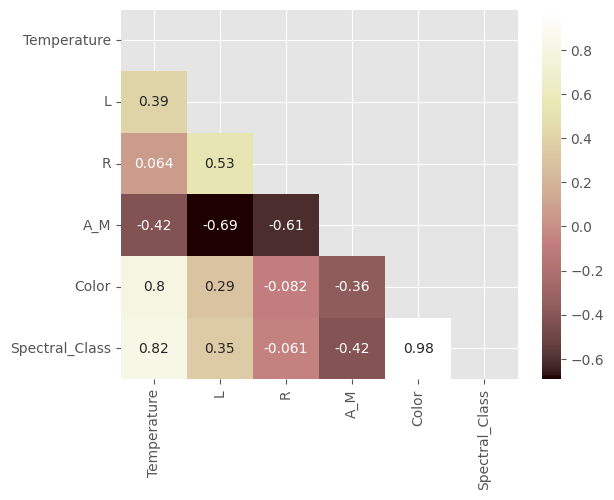

In [9]:

#Matriz de correlación.
corr_df = corregido.corr()
etiquetas = corr_df.columns
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)

# Crear el mapa de calor
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="pink")


·······················································································································································································································································
Con esta matriz de confusión podemos comprobar que las tres variables de entrada Spectral_class, temperature y color estan bastante correladas entre si con una correlación mayor o igual a 0.8 (sobretodo spectral_class con color). También las otras variables A_M,L y R están algo correladas pero muchísimo menos que las anteriores al tener más de 0.6 de correlación (A_M con L y R). Por lo que existe una corelación significativa entre algunas de las variables.
·······················································································································································································································································

·······················································································································································································································································
## PCA DOS DIMENSIONES
·······················································································································································································································································

··························································································································································································································································
En este problema tenemos seis variables de entrada. Para poder graficarlo necesitamos convertirlo en un problema de dos o tres dimensiones. Primero, vamos a transformar los datos de entrada mediante PCA de dos dimensiones.
··························································································································································································································································

In [10]:
X = datos_scaled_df.values
# PCA con 2 componentes principales
pca = PCA(n_components=2)

# Ajustar y transformar los datos
X_trans = pca.fit_transform(X)
df_pca = pd.DataFrame(X_trans, columns=['PC1','PC2'])
#Mostrar las primeros cuatro instancias tras la transformación.
df_pca.head()

,PC1,PC2
0,-2.067808,-0.147152
1,-2.087328,-0.165090
2,-2.188924,-0.236104
3,-2.101169,-0.161525
4,-2.273203,-0.273557


In [11]:
#mÉTRICA DE REPRESENTACIÓN; VARIABILIDAD.
std = df_pca.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.55409866 0.29691252]
Proporción acumulada: [0.55409866 0.85101118]


··························································································································································································································································
Como podemos observar, con dos variables, podemos contemplar el 85% de la varianza explicada del problema, lo que significa que las componentes PC1 y PC2, explican aproximadamente el 85% de la varianza total en los datos.
··························································································································································································································································

··························································································································································································································································
Vamos a graficar como se distribuyen las muestras en las nuevas coordenadas PC1 y PC2 
··························································································································································································································································

<Axes: xlabel='PC1', ylabel='PC2'>

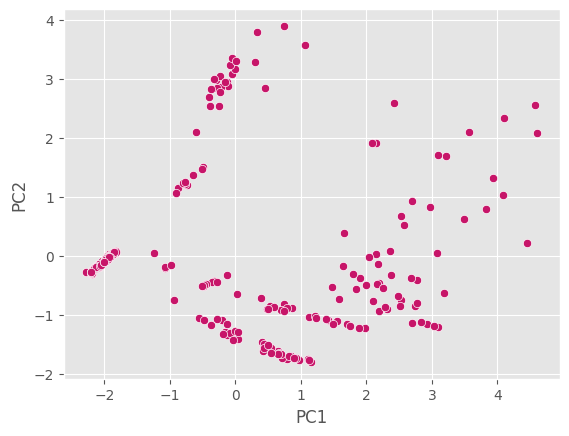

In [12]:
sns.scatterplot(data=df_pca, x="PC1", y="PC2", color='#C71569')

··························································································································································································································································
El gráfico biplot nos da información de cómo se ha realizado la transformación. Nos muestra unos vectores en los que se representan las variables de entrada. Cuanto más paralelo sea una variable al eje de una de las componente, mayor contribución ha aportada en la creación de esa componente. El ángulo también sirve para ver las correlaciones entre las variables y poder comparar a la correlación vista en la matriz. Un ángulo pequeño entre variables indica mayor correlación. Cuánto mayor sea la longitud de una variable mejor estará representada su información en el gráfico.
··························································································································································································································································

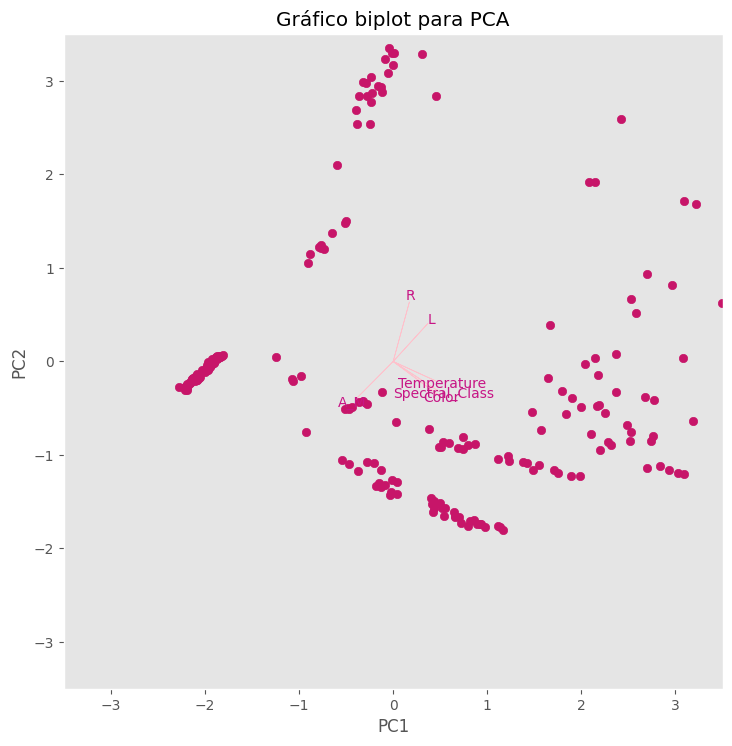

In [13]:
# Función para dibujar un gráfico biplot.
# ==============================================================================

def biplot(scaled_data, fitted_pca, original_dim_labels):

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:,0]
    pca2_scores = pca_results[:,1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores,pca2_scores, color='#C71569')

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i],pca2_scores[i], f'') 

    #for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0,i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1,i]
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2 ,color = 'pink',alpha = 1)
        plt.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, original_dim_labels[i], color = '#C71585', ha = 'center', va = 'center')



#Dibujar el biplot.
plt.figure(figsize=(8.5, 8.5))
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(datos_scaled, pca.fit(datos_scaled), original_dim_labels=data_set.columns)


··························································································································································································································································
Como se puede observar en la gráfica, los ángulos de las variables de entrada Temperatura, Clase espectral y color forman ángulos muy pequeños entre sí lo que afirma su alta correlación. R y L contribuyen más a la creación de la componente PC2, y también se puede ver que su ángulo es pequeño,estando algo correladas entre sí. Las variables de temperatura, color y clase espectral forman casi angulos rectos con las demas variables, por lo que se puede ver que están poco correladas. En el caso de A_M se pueden ver angulos opuestos con R y L, lo que interpretamos como una correlación negativa entre estas variables(AM con L y R).
··························································································································································································································································

----------------------------------------------------------------------------------------------------------------
## NÚMERO DE CLUSTERS
----------------------------------------------------------------------------------------------------------------

··························································································································································································································································
Para determinar el número de cluster vamos a utilizar el metodo silohoutte en vez de el método Elbow Method ya que es más dificil de interpretar. El método silohoutte nos ayudará a determinar el número de cluster a utilizar en nuestros modelos. Cuanto mayor sea el valor de la puntuación, mejor será la estimación(rango del -1 al 1). 
··························································································································································································································································

··························································································································································································································································
Utilizaremos nuestro KMeans Personalizado, para ver el resultado en estos datos mucho más complejos. Aún así, posteriormente haremos la implementación con KMeans de sklearn para ver los resultados que da en comparación con nuestra implementación. KMeans de sklearn será mejor para datos más complejos.
··························································································································································································································································

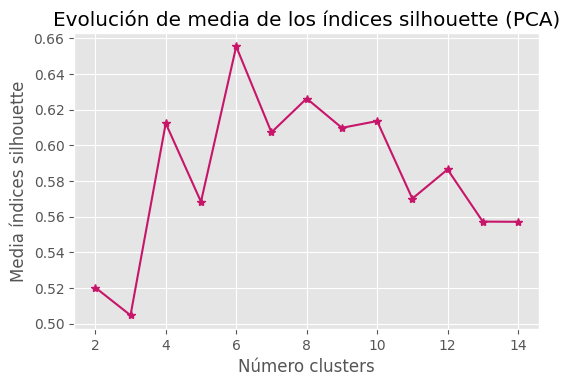

In [14]:

#Implementación con nuestro KMeansP
from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeansP(
        n_clusters=n_clusters
    )
    modelo_kmeans.fit(X=X_trans) 
    cluster_labels = modelo_kmeans.predict(X=X_trans)
    silhouette_avg = silhouette_score(X_trans, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.show()


··························································································································································································································································
Como se puede ver el mejor valor de cluster es 6, por lo que n_clusters, de ahora en adelantes será de seis.
··························································································································································································································································

·········································································································································································································································································
El coeficiente de Silhouette es una medida de evaluación de la calidad de un clustering. Cuanto mayor sea el coeficiente de Silhouette para un punto, más similar es ese punto a su propio grupo y más separado está de otros grupos. Por lo que un 0,65 de esta medida es un resultado bastante bueno.
·········································································································································································································································································

----------------------------------------------------------------------------------------------------------------
## APLICACIÓN DE DIFERENTES ALGORITMOS DE CLUSTERING
----------------------------------------------------------------------------------------------------------------

----------------------------------------------------------------------------------------------------------------
## KMEANS
----------------------------------------------------------------------------------------------------------------

····················································································································································································································································
Para nuestros datos vamos a utilizar el algoritmo de KMEANS personalizado. Es importante conocer antes de aplicar este algoritmo el número de clusters (grupos), anteriormente calculado. Para comenzar, vamos a implementar nuestro algoritmo con K fijado a 4 para compararlo posteriormente con el de seis, que ha sido el indicado en los índices silhoutte.
····················································································································································································································································

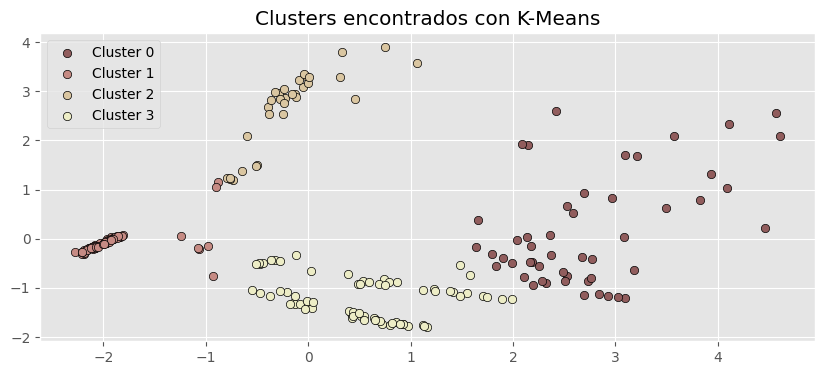

In [15]:
custom_palette = sns.color_palette("pink", 4)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=4).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

#Mostrar gráfica.
plt.show()


·········································································································································································································································································
Con cuatro clusters a simple vista se puede ver como valores bastantes alejados a ciertas clases podrían estar agrupados incorrectamente, por lo que un cluster de 6 aportaría mejores resultados. Un modelo de cuatro clusters generaliza más las clases.
·········································································································································································································································································

Tiempo de ejecución del modelo:  0.01849961280822754


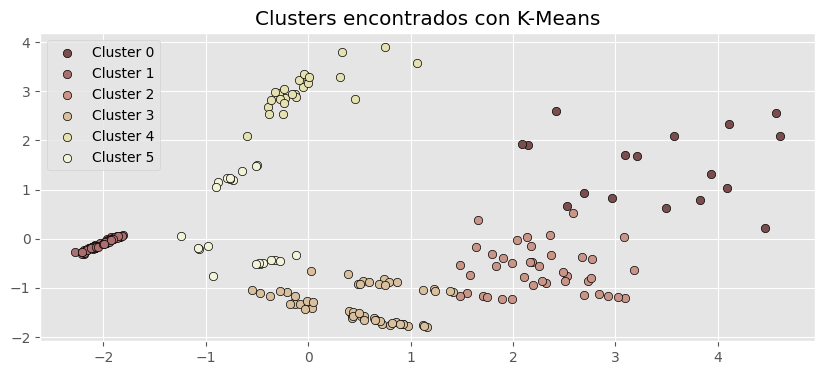

In [16]:
custom_palette = sns.color_palette("pink", 6)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))
start_time = time.time()

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=6).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
total_time_KMeansP = time.time()-start_time
ax.set_title('Clusters encontrados con K-Means')
ax.legend()
print("Tiempo de ejecución del modelo: ", total_time_KMeansP)
#Mostrar gráfica.
plt.show()


·········································································································································································································································································
Esta agrupación es mucho más detallada que la anterior, y segun el indicador silhoutte agrupa mejor los puntos, por lo que un número de seis clusters es mejor que uno de cuatro.
·········································································································································································································································································

·········································································································································································································································································
Vamos a comparar los resultado con K=6, con el modelo de KMEANS de sklearn para comprobar que dan lo mismo o parecido.
·········································································································································································································································································

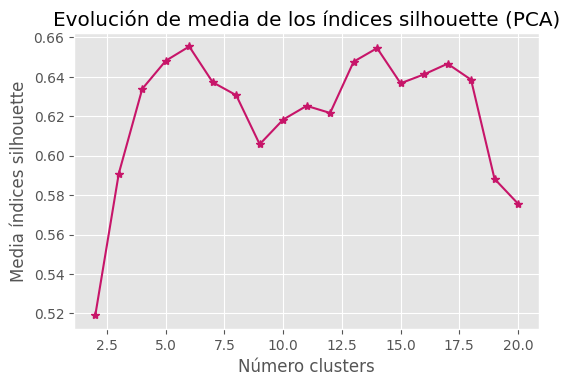

In [17]:

from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 21)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans_sklearn(
        n_clusters=n_clusters,
        n_init=25, 
        random_state=23

    )
    modelo_kmeans.fit(X=X_trans) 
    cluster_labels = modelo_kmeans.predict(X=X_trans)
    silhouette_avg = silhouette_score(X_trans, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')

#Mostrar gráfica.
plt.show()


·········································································································································································································································································
Se puede ver que da más o menos 0,65 igual que con nuestra implementación del algoritmo Kmeans personalizado cuando se trata de seis clusters(algo mejor sklearn). Este modelo de KMeans es más detallado y en esta gráfica de silhoutte se puede ver como clusters de 13 también dan unos buenos resultados pero son demasiadas agrupaciones para este problema de los tipos de estrellas. A ojo se puede ver un poco más alto el de seis igualmente.
·········································································································································································································································································

Tiempo de ejecución del modelo 0.03171277046203613


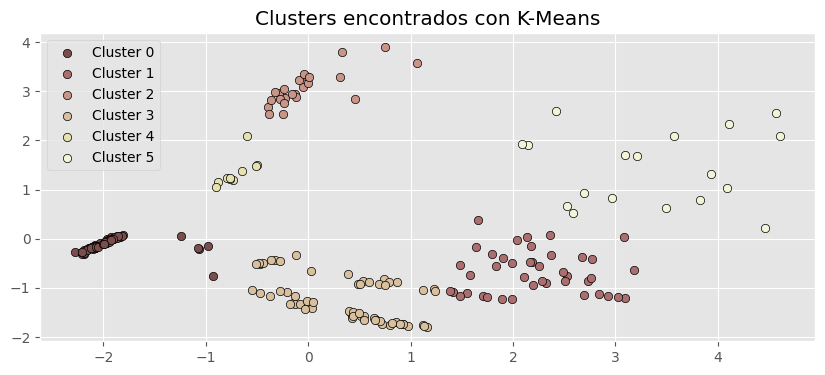

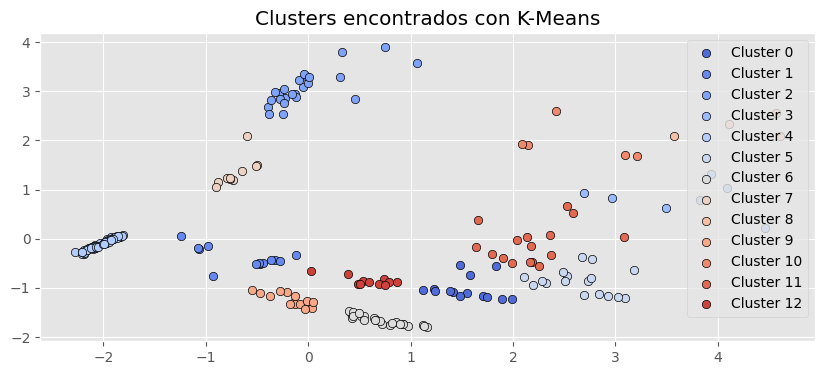

In [18]:
custom_palette = sns.color_palette("pink", 6)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))
start_time = time.time()
# Clustering con tu KMeans personalizado
modelo_kmeans = KMeans_sklearn(n_clusters=6,n_init=25,random_state=23).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)
total_time_KMeans_sklearn = time.time()-start_time
print("Tiempo de ejecución del modelo", total_time_KMeans_sklearn)
for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )

ax.set_title('Clusters encontrados con K-Means')
ax.legend()
#Mostrar gráfica.
plt.show()

# Definir una paleta de colores personalizada en tonos de rosa
custom_palette = sns.color_palette("coolwarm", 13)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeans_sklearn(n_clusters=13,n_init=25,random_state=23).fit(X=X_trans)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

#Mostrar gráfica.
plt.show()



·········································································································································································································································································
Los resultados son muy parecidos o exactamente iguales. Por lo que podemos verificar que nuestra implementación de KMeans agrupa los puntos como el modelo de sklearn (con seis clusters). Para el caso de 13, se puede ver como hace una clasificación mas detallada, pero se puede ver a simple vista que hay grupos de igual solo 4 puntos lo que conlleva a una segmentación más dispersa con clases con pocos números de puntos y menos coherente en comparación con los seis clusters.
·········································································································································································································································································

----------------------------------------------------------------------------------------------------------------
## DBSCAN
----------------------------------------------------------------------------------------------------------------

·········································································································································································································································································
Vamos a utilizar los datos obtenidos en la tranformación PCA, los cuales ya están escalados y permiten verlo en dos dimensiones. Para ello vamos a utilizar el modelo DBSCAN que se trata de otra manera de agrupar los datos en conjuntos, pero esta vez basandose en la densidad de los mismos en el espacio.
·········································································································································································································································································

·········································································································································································································································································
Estos parámetros son utilizados para el modelo DBSCAN:<br>
-eps: Es la distancia máxima entre dos muestras para que una sea considerada como parte del vecindario de la otra. <br>
-min_samples: El número de muestras (o peso total) en un vecindario para que un punto se considere un core point. Esto incluye el propio punto.<br>
-metric: Es la métrica de distancia que se utiliza.
·········································································································································································································································································

·········································································································································································································································································
Este modelo se comparará con los resultados de KMeans para comparar agrupaciones y ver que modelo agrupa mejor los datos.
·········································································································································································································································································

Tiempo de ejecución del modelo
Puntuación de Silhouette para DBSCAN: 0.6072773344804864


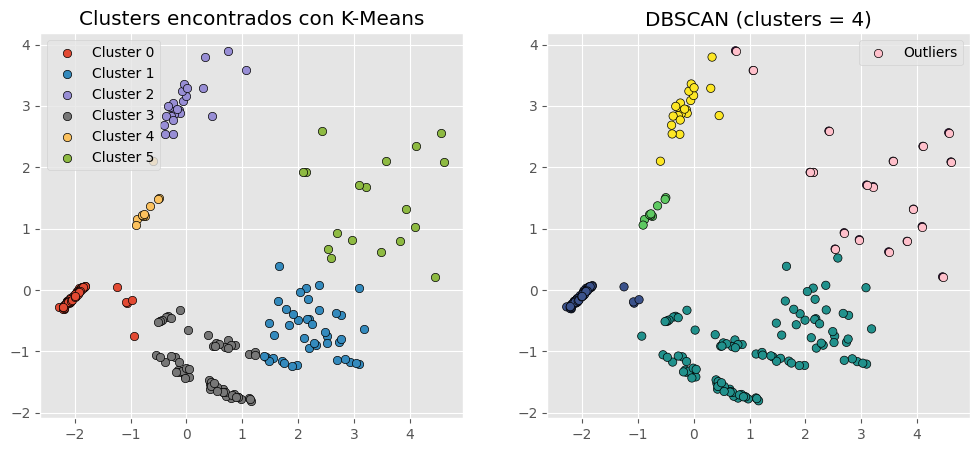

In [19]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Clustering Kmeans
y_predict_Kmeans = KMeans(n_clusters=6, n_init=25, random_state=23).fit_predict(X=X_trans)

# Preparar la figura
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de Kmeans
for i in np.unique(y_predict_Kmeans):
    ax[0].scatter(
        x=X_trans[y_predict_Kmeans == i, 0],
        y=X_trans[y_predict_Kmeans == i, 1],
        c=plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax[0].set_title('Clusters encontrados con K-Means')
ax[0].legend()
start_time= time.time()
# Clustering DBSCAN
modelo_dbscan = DBSCAN(eps=0.6, min_samples=7, metric='euclidean')
labels = modelo_dbscan.fit_predict(X_trans)

# Calcular la puntuación de Silhouette
silhouette_avg = silhouette_score(X_trans, labels)
tiempo_DBSCAN = time.time()- start_time
print("Tiempo de ejecución del modelo",)
# Gráfico de DBSCAN
scatter = ax[1].scatter(
    x=X_trans[:, 0],
    y=X_trans[:, 1],
    c=labels,
    marker='o',
    edgecolor='black'
)

# Outliers identificados con el label -1
outliers = ax[1].scatter(
    x=X_trans[labels == -1, 0],
    y=X_trans[labels == -1, 1],
    c='pink',
    marker='o',
    edgecolor='black',
    label='outliers'
)

ax[1].set_title(f'DBSCAN (clusters = {len(set(labels)) - (1 if -1 in labels else 0)})')
ax[1].legend(handles=[outliers], labels=['Outliers'])

# Imprimir la puntuación de Silhouette
print(f'Puntuación de Silhouette para DBSCAN: {silhouette_avg}')

plt.show()


·········································································································································································································································································
A continuación, mostramos cuantas clusters crea el modelo y la cantidad de puntos que ha determinado como ruido.
·········································································································································································································································································

In [20]:
# Número de clusters y observaciones "outliers"
# ==============================================================================
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise    = list(labels).count(-1)

print(f'Número de clusters encontrados: {n_clusters}')
print(f'Número de outliers encontrados: {n_noise}')

Número de clusters encontrados: 4
Número de outliers encontrados: 19


·········································································································································································································································································
Como se puede ver DBSCAN agrupa el modelo solamente en 4 clusters, por lo que generaliza más las agrupaciones y hay bastantes outliers que podrian ser parte de otra clase en vez de ser considerados valores atípicos. KMeans consideramos que hace mejor agrupación. Al utilizar datos muy dispersos DBSCAN no es el mejor modelo, ya que se basa en buscar grupos en función de su densidad. 
·········································································································································································································································································

----------------------------------------------------------------------------------------------------------------
## KMEDOIDS
----------------------------------------------------------------------------------------------------------------

·········································································································································································································································································
Vamos a utilizar los datos obtenidos en la tranformación PCA, los cuales ya están escalados y permiten verlo en dos dimensiones. Para ello vamos a utilizar el modelo KMedoids. La gráfica que se va a mostrar muestra el medoid, que es el punto central del cluster, el promedio de todos los puntos que componen ese cluster.
·········································································································································································································································································

·········································································································································································································································································
Primero vamos a utilizar la métrica silohoutte, para ver que numero de clusters es el mejor para este modelo segun el indicador. Posteriormente realizaremos el modelo con el mejor n_cluster obtenido.
·········································································································································································································································································

·········································································································································································································································································
Los parámetros a utilzar para intentar obtener los mejores resultados son los siguientes:<br>
-n_clusters: Número de clusters a buscar.<br>
-init: Método de inicialización de medoides.<br>
-metric: Es la métrica de distancia que utiliza, la predeterminada es la euclidiana.<br>
-max_iter: Como predeterminado es 300, es el máximo número de iteracones.<br>
·········································································································································································································································································


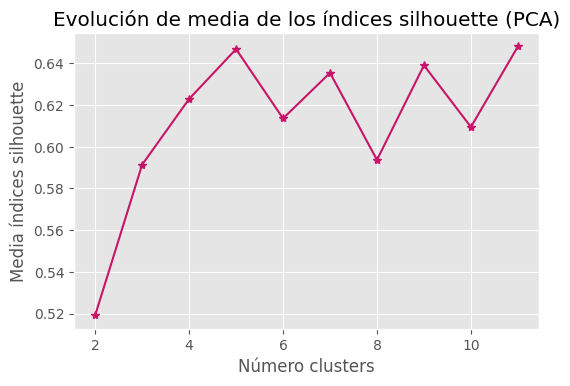

In [21]:

from sklearn_extra.cluster import KMedoids
range_n_clusters = range(2, 12)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMedoids(
        n_clusters=n_clusters,
        random_state = 23,
        method='pam'
    )
    modelo_kmeans.fit(X=X_trans) 
    cluster_labels = modelo_kmeans.predict(X=X_trans)
    silhouette_avg = silhouette_score(X_trans, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.show()


·········································································································································································································································································
Probamos el metodo con el K recomendado por el indicador de silohoutte.
·········································································································································································································································································

In [22]:
# Ejecutar K-Medoids con tus datos X_trans
start_time = time.time()
modelo_kmedoids = KMedoids(n_clusters=5, random_state=23, method='pam')
modelo_kmedoids.fit(X=X_trans)
y_predict = modelo_kmedoids.predict(X=X_trans)
#Tiempo del modelo.
tiempo_KMedoids = time.time()
print("Tiempo de ejecución del modelo", tiempo_KMedoids)

Tiempo de ejecución del modelo 1715354810.4363253


·········································································································································································································································································
A continuación, realizamos la gráfica que muestra como el modelo KMedoids clasifica los puntos en los distintos clusters(cada uno un color distinto).
·········································································································································································································································································

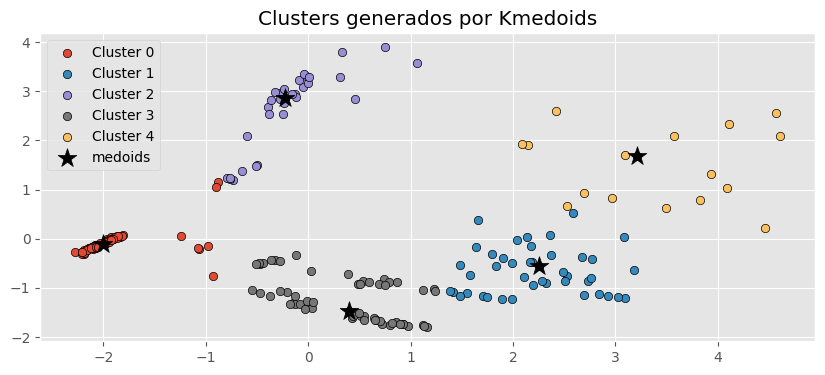

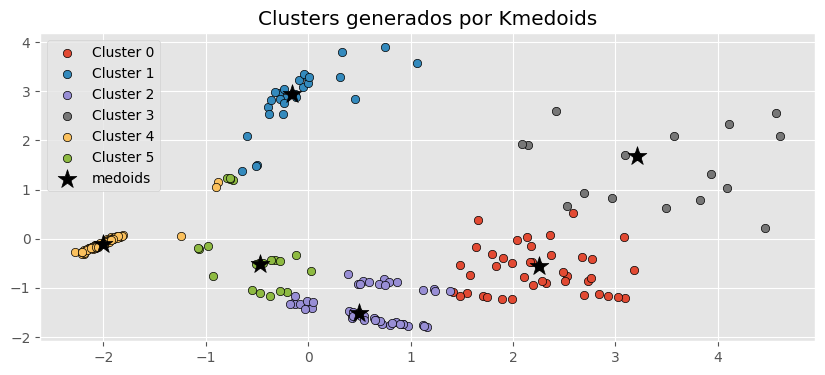

In [23]:
# Representación gráfica: grupos originales vs clusters creados
# ==============================================================================
fig, ax = plt.subplots(1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_trans[y_predict == i, 0],
        y = X_trans[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmedoids.cluster_centers_[:, 0],
    y = modelo_kmedoids.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'medoids'
)
ax.set_title('Clusters generados por Kmedoids')
ax.legend();

# Ejecutar K-Medoids con tus datos X_trans
modelo_kmedoids = KMedoids(n_clusters=6, random_state=23, method='pam')
modelo_kmedoids.fit(X=X_trans)
y_predict = modelo_kmedoids.predict(X=X_trans)

fig, ax = plt.subplots(1, figsize=(10, 4))

for i in np.unique(y_predict):
    ax.scatter(
        x = X_trans[y_predict == i, 0],
        y = X_trans[y_predict == i, 1],
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black',
        label= f"Cluster {i}"
    )

ax.scatter(
    x = modelo_kmedoids.cluster_centers_[:, 0],
    y = modelo_kmedoids.cluster_centers_[:, 1],
    c = 'black',
    s = 200,
    marker = '*',
    label  = 'medoids'
)
ax.set_title('Clusters generados por Kmedoids')
ax.legend();

·········································································································································································································································································
Esta gráfica muestra los medoides de cada clase, que es el punto céntrico de cada agrupación. Con una K=5, nos sale una gráfica que agrupa bien los datosy da un 0,64 en la m´étrica de Silhoutte a probar con K=6, la métrica Silhoutte da 0,62 pero consideramos que esta agruoación es mejor ya que no hay mucha diferencia entre ambos resultados y la clasificación es más específica.
·········································································································································································································································································

----------------------------------------------------------------------------------------------------------------
## GAUSSIAN MIXTURE MODEL
----------------------------------------------------------------------------------------------------------------

·········································································································································································································································································
Un Gaussian Mixture model es un modelo probabilístico en el que se considera que las observaciones siguen una distribución probabilística formada por la combinación de múltiples distribuciones normales (componentes).
·········································································································································································································································································

·········································································································································································································································································
Los distintos parámetros de este modelo utilizado son:<br>
-n_components: Números de clusters.<br>
-covariance_type: tipo de matriz de covarianza.<br>
-random_state: semilla para garantizar la reproducibilidad de los resultados.
·········································································································································································································································································


In [24]:
# Modelo
# ==============================================================================
# Inicializar y ajustar el modelo KMeans
kmeans = KMeans(n_clusters=6, init='k-means++')
kmeans.fit(X_trans)
initial_means = kmeans.cluster_centers_

# Inicializar y ajustar el modelo GMM usando los centroides de KMeans como inicialización
modelo_gmm = GaussianMixture(n_components=6, covariance_type='full', means_init=initial_means)
modelo_gmm.fit(X_trans)

GaussianMixture(means_init=array([[-1.9669128 , -0.11602542],
       [ 2.22250184, -0.65198084],
       [-0.02838973,  3.07133875],
       [ 0.35428576, -1.22433722],
       [ 3.39932867,  1.48978936],
       [-0.70986569,  1.35433582]]),
                n_components=6)

·········································································································································································································································································
Vamos a calcular la media de cada componente.
·········································································································································································································································································

In [25]:
# Media de cada componente
modelo_gmm.means_

array([[-2.02361984, -0.10754706],
       [ 2.07115825, -0.76251738],
       [-0.0512061 ,  3.0323818 ],
       [ 0.18818957, -1.16282683],
       [ 3.18236512,  1.2033238 ],
       [-0.72259997,  1.2716081 ]])

·········································································································································································································································································
Esta es la matriz de covarianza que genera el modelo.
·········································································································································································································································································

In [26]:
# Matriz de covarianza de cada componente
modelo_gmm.covariances_

array([[[ 0.01346308,  0.01208326],
        [ 0.01208326,  0.01123794]],

       [[ 0.38163672,  0.02926722],
        [ 0.02926722,  0.14201117]],

       [[ 0.13553872,  0.10919202],
        [ 0.10919202,  0.14929666]],

       [[ 0.37370015, -0.23784667],
        [-0.23784667,  0.25980114]],

       [[ 0.76623707,  0.22473613],
        [ 0.22473613,  0.77687368]],

       [[ 0.01859233,  0.0188524 ],
        [ 0.0188524 ,  0.01988691]]])

·········································································································································································································································································
Probabilidad de los puntos de pertenecer a cada una de las componentes (clusters).
·········································································································································································································································································

In [27]:
# Probabilidades
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
probabilidades = modelo_gmm.predict_proba(X_trans)
probabilidades

array([[9.99995416e-001, 4.64843227e-014, 7.11887224e-018,
        4.58400925e-006, 1.34326362e-011, 7.71724980e-024],
       [9.99996101e-001, 4.53337960e-014, 5.43676570e-018,
        3.89888327e-006, 1.27460573e-011, 2.29057341e-024],
       [9.99995769e-001, 8.61903273e-014, 5.84637894e-018,
        4.23083592e-006, 2.48214598e-011, 1.80939075e-026],
       ...,
       [0.00000000e+000, 3.27262420e-016, 1.51629463e-029,
        2.91021655e-055, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 2.11974273e-010, 8.23841980e-035,
        6.04123089e-038, 1.00000000e+000, 0.00000000e+000],
       [0.00000000e+000, 1.45949942e-007, 7.00086152e-111,
        4.00351403e-055, 9.99999854e-001, 0.00000000e+000]])

·········································································································································································································································································
Matriz de clasificación de los puntos en los clusters.
·········································································································································································································································································

In [28]:
# Clasificación (asignación a la componente de mayor probabilidad)
# ==============================================================================
# Cada fila es una observación y cada columna la probabilidad de pertenecer a
# cada una de las componentes.
clasificacion = modelo_gmm.predict(X_trans)
clasificacion

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 4, 1, 1, 1, 1, 1, 1, 1, 1,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 1, 1,
       1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 4, 2, 2,
       4, 4, 4, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 3, 3, 1, 1, 1, 3, 1, 1, 3,
       1, 1, 1, 4, 1, 1, 4, 4, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4])

······························································································································································································································································
Como el método silohoutte es la métrica utilizada para determinar el número de clusters, se ha calculado más abajo el n_clusters(componentes) recomendados para este modelo. Por lo que K=6, según el resultado obtenido. 
······························································································································································································································································

Tiempo de ejecución del modelo 0.03282594680786133
Número de componentes del mejor modelo según el AIC: 6
Número de componentes del mejor modelo según el BIC: 6


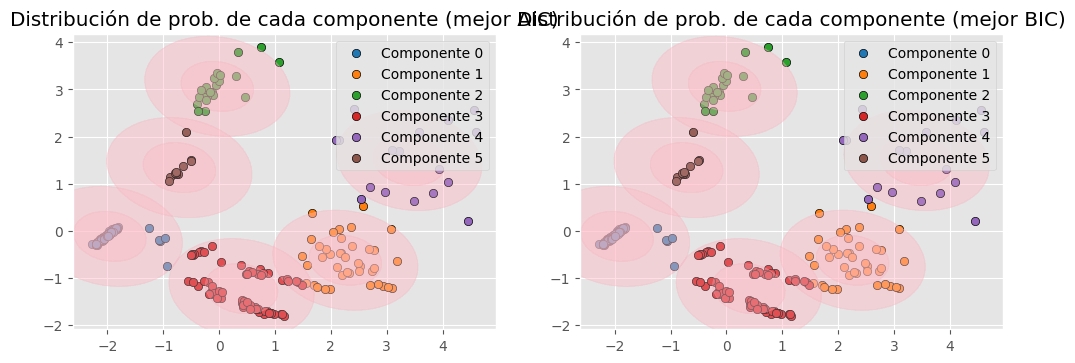

In [29]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from sklearn.mixture import GaussianMixture

# Definir la función make_ellipses
def make_ellipses(gmm, ax):
    for n in range(gmm.n_components):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)

        for i in range(1, 3):
            ell = mpl.patches.Ellipse((gmm.means_[n, 0], gmm.means_[n, 1]), i * v[0], i * v[1], angle=180 + angle, color="pink")
            ell.set_clip_box(ax.bbox)
            ell.set_alpha(0.1)
            ax.add_artist(ell)

# Entrenar varios modelos GMM con diferentes números de componentes
n_components_range = range(1, 9)
start_time = time.time()
models = [GaussianMixture(n_components=6, covariance_type='tied', random_state=23, init_params='kmeans').fit(X_trans) for n in n_components_range]

# Calcular AIC y BIC para cada modelo
aics = [model.aic(X_trans) for model in models]
bics = [model.bic(X_trans) for model in models]

# Seleccionar el modelo con el menor AIC y BIC
best_aic_model = models[np.argmin(aics)]
best_bic_model = models[np.argmin(bics)]
tiempo_Gaussian = time.time()- start_time
print("Tiempo de ejecución del modelo", tiempo_Gaussian)
# Imprimir el número de componentes del mejor modelo según el AIC y el BIC
print("Número de componentes del mejor modelo según el AIC:", best_aic_model.n_components)
print("Número de componentes del mejor modelo según el BIC:", best_bic_model.n_components)


# Crear la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(12, 3.84))

# Distribución de probabilidad de cada componente para el mejor modelo AIC
for i in range(best_aic_model.n_components):
    axs[0].scatter(
        x=X_trans[best_aic_model.predict(X_trans) == i, 0],
        y=X_trans[best_aic_model.predict(X_trans) == i, 1],
        c=plt.cm.tab10(i),
        marker='o',
        edgecolor='black',
        label=f"Componente {i}"
    )
    make_ellipses(best_aic_model, ax=axs[0])

axs[0].set_title('Distribución de prob. de cada componente (mejor AIC)')
axs[0].legend()

# Distribución de probabilidad de cada componente para el mejor modelo BIC
for i in range(best_bic_model.n_components):
    axs[1].scatter(
        x=X_trans[best_bic_model.predict(X_trans) == i, 0],
        y=X_trans[best_bic_model.predict(X_trans) == i, 1],
        c=plt.cm.tab10(i),
        marker='o',
        edgecolor='black',
        label=f"Componente {i}"
    )
    make_ellipses(best_bic_model, ax=axs[1])

axs[1].set_title('Distribución de prob. de cada componente (mejor BIC)')
axs[1].legend()

plt.show()


······························································································································································································································································
Dado que los modelos GMM son modelos probabilísticos, se puede recurrir a métricas como AIC o BIC para identificar cómo de bien se ajustan los datos observados a modelo creado. Al Bic y Aicc ser métricas que se centran más en la complejidad y ajuste del modelo y dan como mejor resulatado K=20, demasiada agrupación de las clases, consideramos que la métrica de silhoutte es mejor para determinar el número de clusters de este modelo, ya que se centra más en qué tan bien están separados los clusters y evaluar la calidad de estas agrupaciones.
······························································································································································································································································

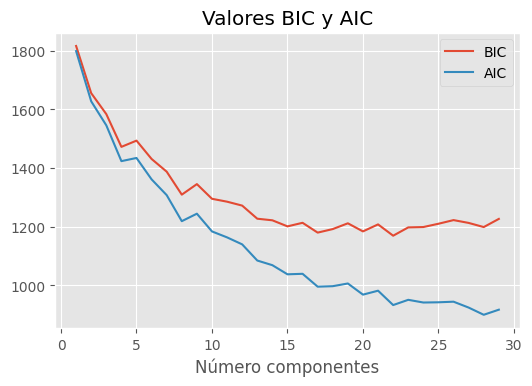

In [30]:
n_components = range(1, 30)
valores_bic = []
valores_aic = []

for i in n_components:
    modelo = GaussianMixture(n_components=i, covariance_type="tied")
    modelo = modelo.fit(X_trans)
    valores_bic.append(modelo.bic(X_trans))
    valores_aic.append(modelo.aic(X_trans))

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(n_components, valores_bic, label='BIC')
ax.plot(n_components, valores_aic, label='AIC')
ax.set_title("Valores BIC y AIC")
ax.set_xlabel("Número componentes")
ax.legend()

In [31]:
print(f"Número óptimo acorde al BIC: {range(1, 30)[np.argmin(valores_bic)]}")
print(f"Número óptimo acorde al AIC: {range(1, 30)[np.argmin(valores_aic)]}")

Número óptimo acorde al BIC: 22
Número óptimo acorde al AIC: 28


·········································································································································································································································································
La cantidad de clusters que estas métricas dan como valor óptimo consideramos que son demasidas clases para agrupar estos datos. Por lo que utilizaremos Silhoutte.
·········································································································································································································································································

·········································································································································································································································································
Vamos a generar cuatro gráficas cambiando el parámetro covariance_type:<br>
-full: en este tipo de covarianza cada componente tiene su propia matriz de covarianza, aquí estamos considerando todas las combinaciones posibles de cómo las variables cambian juntas.
-tied: aquí todos los componentes comparten la misma matriz de covarianza, es decir, estamos diciendo que todas las variables están más o menos relacionadas de la misma manera<br>
-diag: Aquí, solo nos preocupamos por la variación de cada variable por sí sola, sin tener en cuenta cómo se relaciona con otras variables.<br>
-spherical: En este caso, estamos diciendo que todas las variables son independientes entre sí y tienen la misma importancia.<br>
·········································································································································································································································································


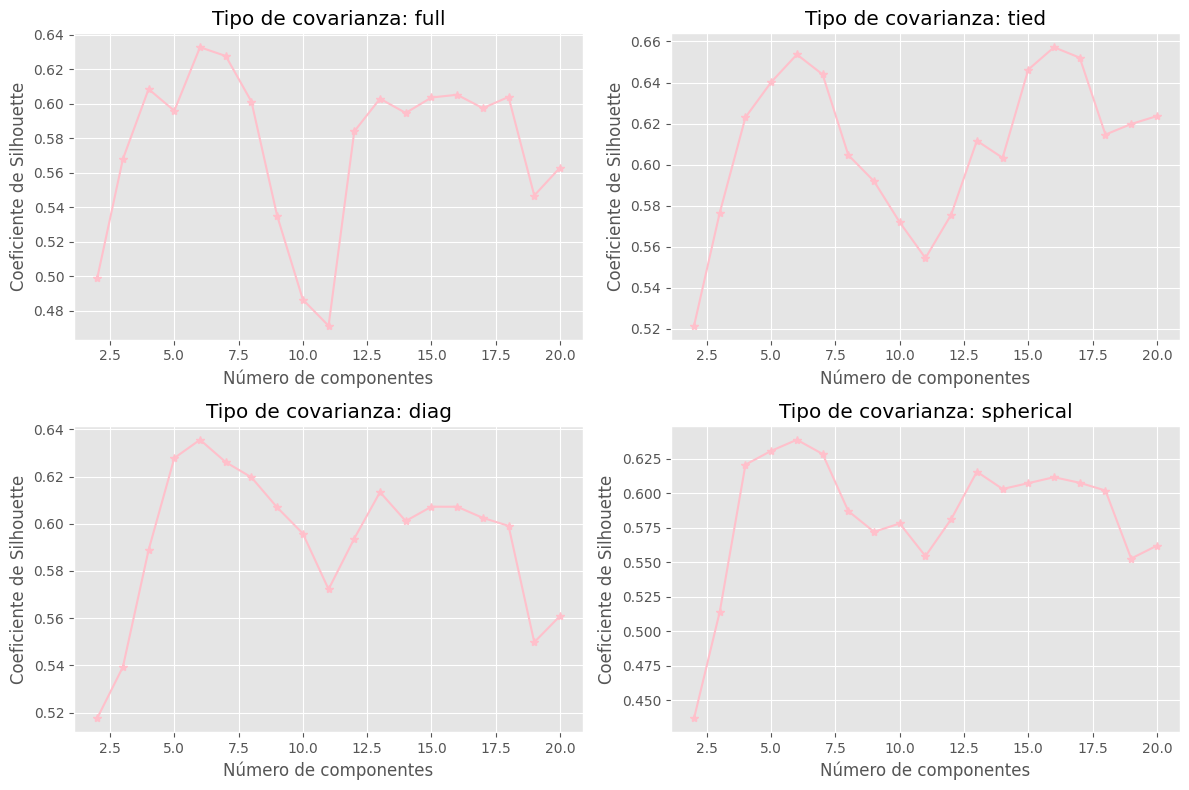

In [32]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define el rango de posibles números de componentes
n_components_range = range(2, 21)

# Lista para almacenar los valores de Silhouette para cada tipo de matriz de covarianza
silhouette_scores = {'full': [], 'tied': [], 'diag': [], 'spherical': []}

# Itera sobre el rango de números de componentes
for n_components in n_components_range:
    for cov_type in silhouette_scores.keys():
        # Ajusta el modelo de mezcla gaussiana con el tipo de covarianza actual
        gmm = GaussianMixture(n_components=n_components, covariance_type=cov_type, random_state=23)
        gmm.fit(X_trans)
        
        # Predice las etiquetas de los clusters
        cluster_labels = gmm.predict(X_trans)
        
        # Calcula el coeficiente de Silhouette
        silhouette_avg = silhouette_score(X_trans, cluster_labels)
        
        # Almacena el valor de Silhouette para el tipo de covarianza actual
        silhouette_scores[cov_type].append(silhouette_avg)

# Crea un cuadro de cuatro gráficos
fig, axs = plt.subplots(2, 2, figsize=(12, 8))
axs = axs.flatten()

# Itera sobre cada tipo de covarianza y traza los valores de Silhouette
for i, (cov_type, scores) in enumerate(silhouette_scores.items()):
    axs[i].plot(n_components_range, scores, marker='*',color='pink')
    axs[i].set_xlabel('Número de componentes')
    axs[i].set_ylabel('Coeficiente de Silhouette')
    axs[i].set_title(f'Tipo de covarianza: {cov_type}')

plt.tight_layout()
plt.show()


······························································································································································································································································
El coeficiente de Silohoutte con mejor resultado es el de seis y utilizando covarianze_type; tied, por ello el modelo inicial utiliuza este número de componentes y ese tipo de covarianza.
······························································································································································································································································

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
## CLUSTER JERÁRQUICO
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

······························································································································································································································································
Es fundamental escalar los datos antes de aplicar este tipo de algoritmo.
······························································································································································································································································

In [33]:
# Escalado de las variables.
# ==============================================================================
datos_scaled = scale(X=corregido, axis=0, with_mean=True, with_std=True)
datos_scaled = pd.DataFrame(datos_scaled, columns=corregido.columns, index=corregido.index)
datos_scaled.head(4)

,Temperature,L,R,A_M,Color,Spectral_Class
0,-0.779382,-0.598624,-0.459210,1.116745,-1.008818,-0.997781
1,-0.782110,-0.598624,-0.459241,1.162414,-1.008818,-0.997781
2,-0.828477,-0.598624,-0.459342,1.362213,-1.008818,-0.997781
3,-0.807496,-0.598624,-0.459229,1.167171,-1.008818,-0.997781


······························································································································································································································································
Los parámetros clave del cluster jerarquico son:<br>
-n_clusters: Define el número de clusters. Puede ser None si se utiliza distance_threshold para definir los clusters o para generar todo el dendrograma.<br>
-distance_threshold: La distancia a partir de la cual los clusters dejan de fusionarse. Si es cero se genera todo el dendograma.<br>
-linkage: El tipo de linkage utilizado, como "ward", "complete", "average", o "single".
······························································································································································································································································

······························································································································································································································································
El linkage determina cómo se mide la distancia entre los pares de grupos durante el proceso de fusión en el clustering aglomerativo.<br>
"ward": En cada etapa del algoritmo, se eligen los pares de clusters cuya fusión resulta en el menor aumento en la varianza total dentro de los clusters combinados. <br>
"complete": Utiliza la distancia máxima entre todos los puntos de los dos clusters.<br>
"average": Utiliza el promedio de las distancias entre todos los puntos de los dos clusters.
······························································································································································································································································

In [34]:
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, labels=None, **kwargs):
    '''
    Esta función extrae la información de un modelo AgglomerativeClustering
    y representa su dendograma con la función dendogram de scipy.cluster.hierarchy
    '''

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot
    if labels is not None:
        dendrogram(linkage_matrix, labels=labels, **kwargs)
    else:
        dendrogram(linkage_matrix, **kwargs)


In [35]:
# Modelos
# ==============================================================================
modelo_hclust_complete = AgglomerativeClustering(
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=datos_scaled)

modelo_hclust_average = AgglomerativeClustering(
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=datos_scaled)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=datos_scaled)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

······························································································································································································································································
Vamos a ver como clasifica el modelo con los distitos linkage y limitando el modelo a una profundidad de siete para que no se nos generen gráfico con mucha profundidad y se pueda interpretar mejor.
······························································································································································································································································

Tiempo de ejecución del modelo con avg 0.1838228702545166
Tiempo de ejecución del modelo con avg 0.07411360740661621
Tiempo de ejecución del modelo con avg 0.13990306854248047


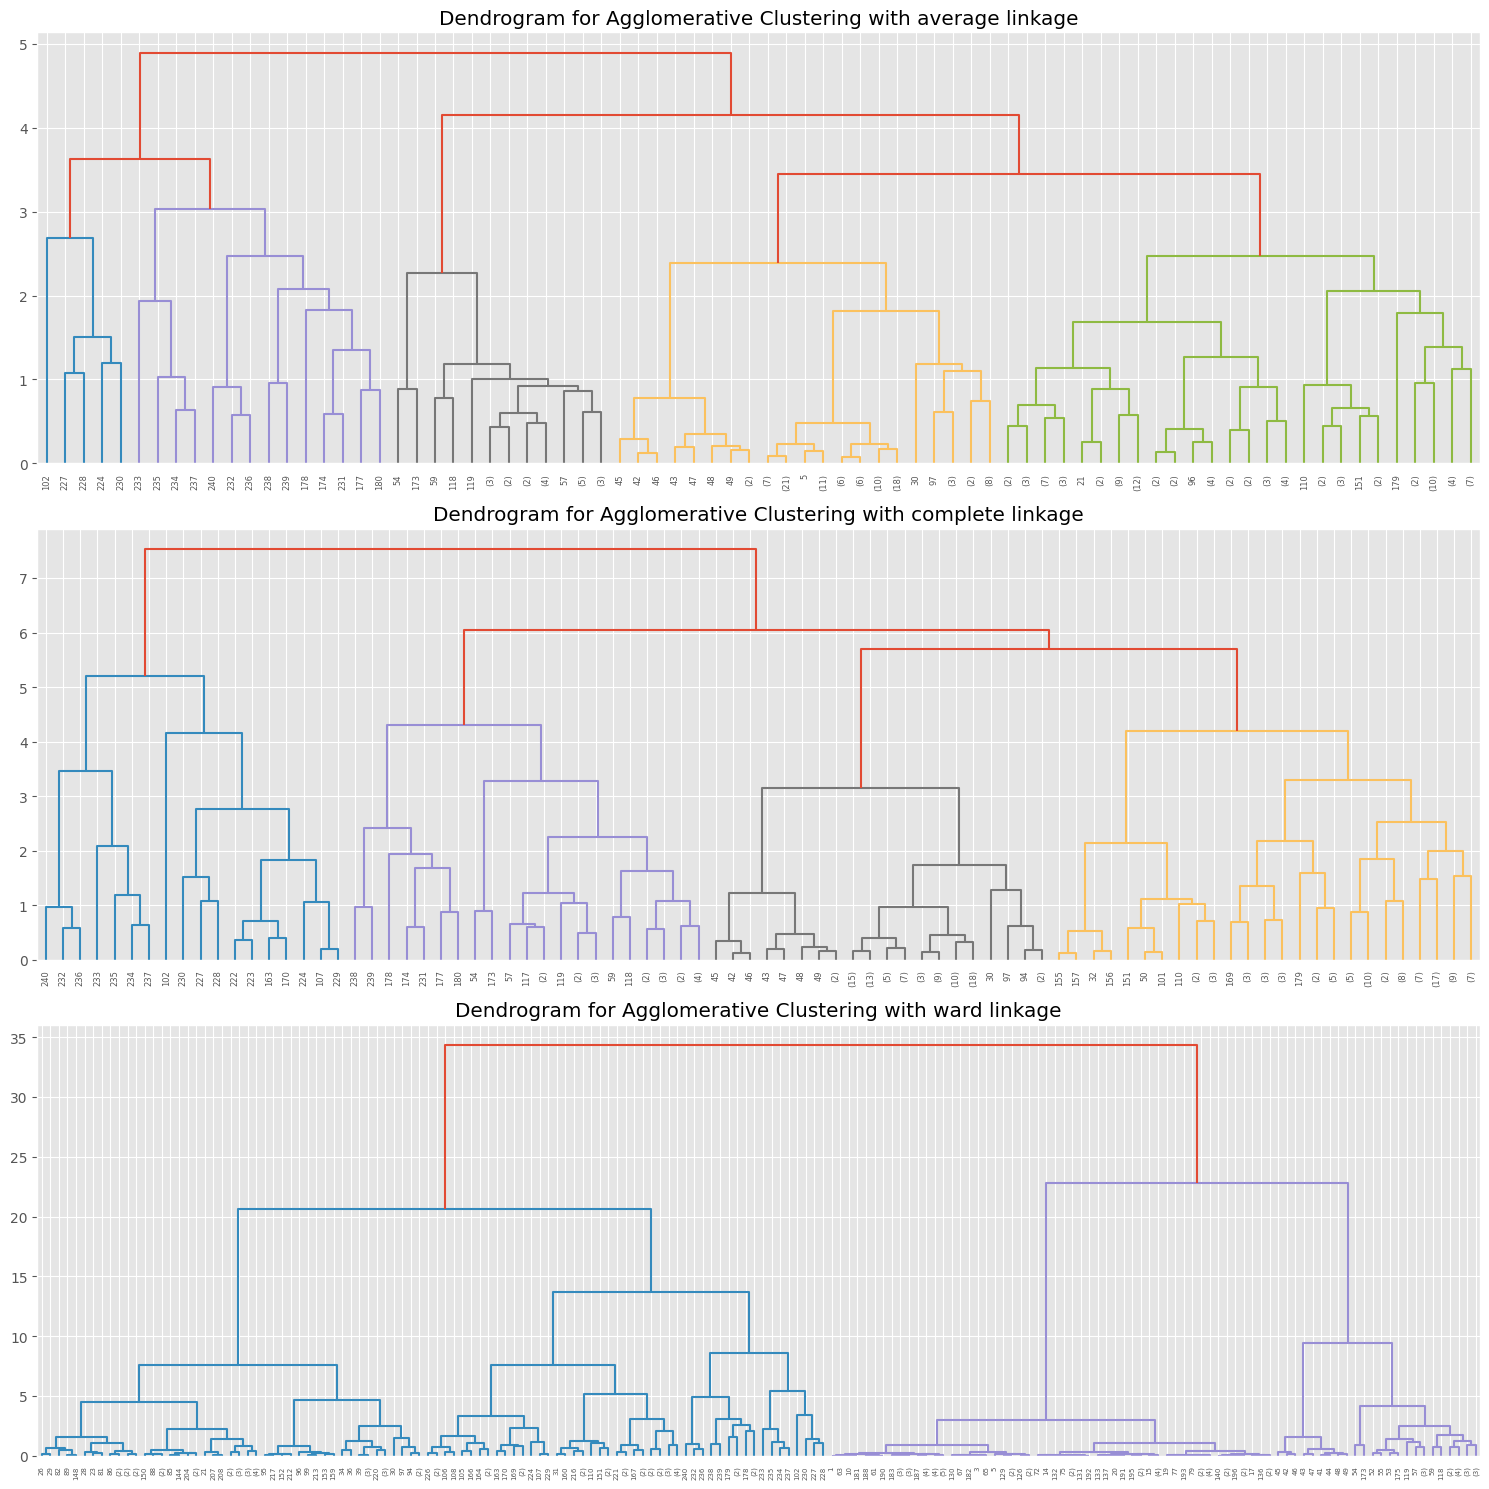

In [36]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

# Plot dendrograms
plt.figure(figsize=(15, 15))

linkage_matrix_comp = linkage(datos_scaled, method='complete')
linkage_matrix_avg = linkage(datos_scaled, method='average')
linkage_matrix_ward = linkage(datos_scaled, method='ward')

start_time = time.time()
# Dendrograma con enlace promedio
plt.subplot(3, 1, 1)
dendrogram(linkage_matrix_avg, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
plt.title('Dendrogram for Agglomerative Clustering with average linkage')
tiempo_Agglomerative_avg = time.time()- start_time
print("Tiempo de ejecución del modelo con avg", tiempo_Agglomerative_avg)

start_time = time.time()
# Dendrograma con enlace completo
plt.subplot(3, 1, 2)
dendrogram(linkage_matrix_comp, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
plt.title('Dendrogram for Agglomerative Clustering with complete linkage')
tiempo_Agglomerative_comp = time.time()- start_time
print("Tiempo de ejecución del modelo con avg", tiempo_Agglomerative_comp)

start_time = time.time()
# Dendrograma con enlace ward
plt.subplot(3, 1, 3)
dendrogram(linkage_matrix_ward, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
plt.title('Dendrogram for Agglomerative Clustering with ward linkage')
tiempo_Agglomerative_ward = time.time()- start_time
print("Tiempo de ejecución del modelo con avg", tiempo_Agglomerative_ward)

plt.tight_layout()
plt.show()


······························································································································································································································································
Vamos a establecer la altura de corte, las clases a las que corte serán en número de cluster correspondiente.
······························································································································································································································································

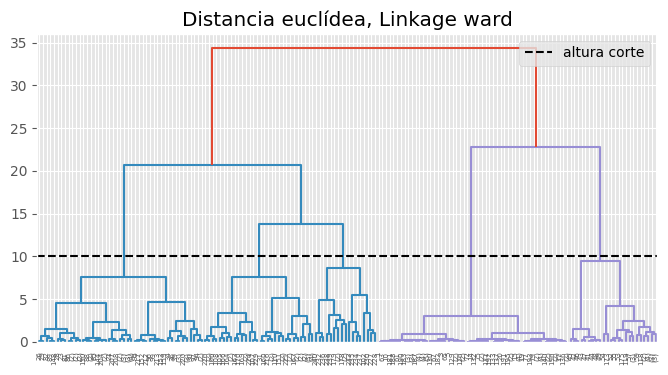

In [37]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 10
dendrogram(linkage_matrix_ward, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

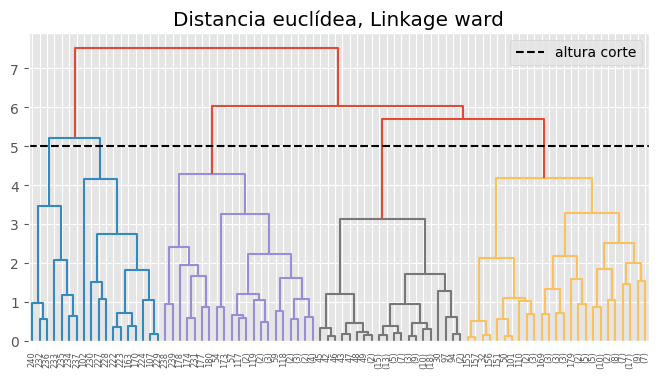

In [38]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 5
dendrogram(linkage_matrix_comp, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

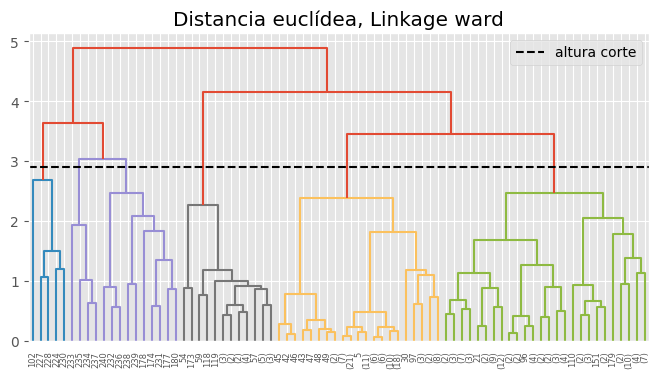

In [39]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
altura_corte = 2.9
dendrogram(linkage_matrix_avg, labels=np.arange(1, len(datos_scaled) + 1), truncate_mode='level', p=7)
ax.set_title("Distancia euclídea, Linkage ward")
ax.axhline(y=altura_corte, c = 'black', linestyle='--', label='altura corte')
ax.legend();

······························································································································································································································································
La altura de corte ha sido selecionada a partie de cuando se ve que se clasifica mejor cada modelo. Por lo que en complete y avg son 5 y en ward son seis los clusters según la altura de corte que hemos definido.
······························································································································································································································································

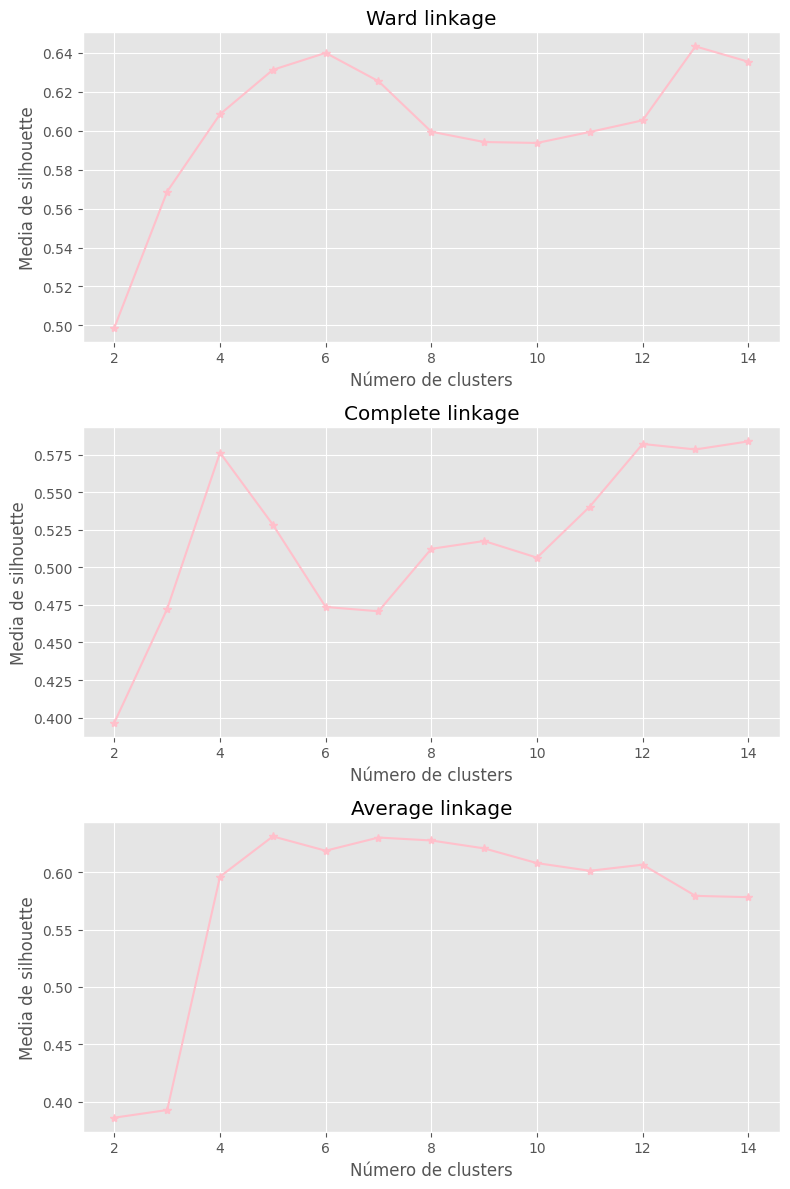

In [40]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define el rango de posibles números de clusters
range_n_clusters = range(2, 15)

# Lista para almacenar los valores medios de silhouette
valores_medios_silhouette_ward = []
valores_medios_silhouette_complete = []
valores_medios_silhouette_average = []

# Itera sobre el rango de números de clusters
for n_clusters in range_n_clusters:
    # Método de enlace: ward
    modelo_ward = AgglomerativeClustering(linkage='ward', n_clusters=n_clusters)
    cluster_labels_ward = modelo_ward.fit_predict(X_trans)
    silhouette_avg_ward = silhouette_score(X_trans, cluster_labels_ward)
    valores_medios_silhouette_ward.append(silhouette_avg_ward)
    
    # Método de enlace: complete
    modelo_complete = AgglomerativeClustering(linkage='complete', n_clusters=n_clusters)
    cluster_labels_complete = modelo_complete.fit_predict(X_trans)
    silhouette_avg_complete = silhouette_score(X_trans, cluster_labels_complete)
    valores_medios_silhouette_complete.append(silhouette_avg_complete)
    
    # Método de enlace: average
    modelo_average = AgglomerativeClustering(linkage='average', n_clusters=n_clusters)
    cluster_labels_average = modelo_average.fit_predict(X_trans)
    silhouette_avg_average = silhouette_score(X_trans, cluster_labels_average)
    valores_medios_silhouette_average.append(silhouette_avg_average)

# Graficar los valores medios de silhouette para cada método de enlace
fig, axs = plt.subplots(3, 1, figsize=(8, 12))

# Método de enlace: ward
axs[0].plot(range_n_clusters, valores_medios_silhouette_ward, marker='*',color='pink')
axs[0].set_title('Ward linkage')
axs[0].set_xlabel('Número de clusters')
axs[0].set_ylabel('Media de silhouette')

# Método de enlace: complete
axs[1].plot(range_n_clusters, valores_medios_silhouette_complete, marker='*',color='pink')
axs[1].set_title('Complete linkage')
axs[1].set_xlabel('Número de clusters')
axs[1].set_ylabel('Media de silhouette')

# Método de enlace: average
axs[2].plot(range_n_clusters, valores_medios_silhouette_average, marker='*',color='pink')
axs[2].set_title('Average linkage')
axs[2].set_xlabel('Número de clusters')
axs[2].set_ylabel('Media de silhouette')

plt.tight_layout()
plt.show()


······························································································································································································································································
El linkage ward es el que mejor número de clusters da, es decir, tiene una tendencia a formar agrupaciones más coherentes en comparación con otros métodos de enlace.
······························································································································································································································································

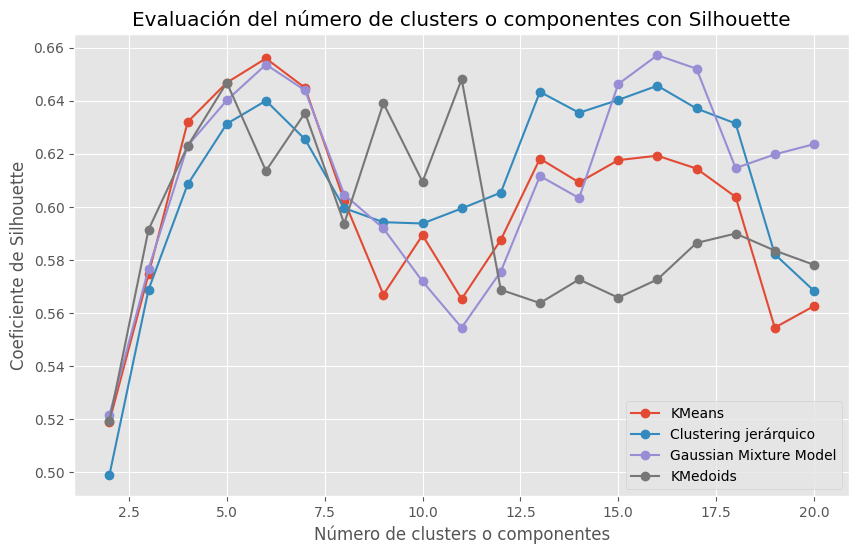

In [41]:
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Define el rango de posibles números de clusters o componentes
n_range = range(2, 21)

# Lista para almacenar los valores de Silhouette de cada modelo
silhouette_scores_kmeans = []
silhouette_scores_hclust = []
silhouette_scores_gmm = []
silhouette_scores_kmedoids = []

# Itera sobre el rango de números de clusters o componentes
for n in n_range:
    # Ajusta el modelo KMeans
    modelo_kmeans = KMeans(n_clusters=n, random_state = 23)
    modelo_kmeans = KMeans(n_clusters=n, random_state = 23).fit(X=X_trans)
    cluster_labels_kmeans = modelo_kmeans.predict(X=X_trans)
    silhouette_avg_kmeans = silhouette_score(X_trans, cluster_labels_kmeans)
    silhouette_scores_kmeans.append(silhouette_avg_kmeans)
    
    # Ajusta el modelo de clustering jerárquico
    modelo_hclust = AgglomerativeClustering(linkage='ward',n_clusters=n)
    cluster_labels_hclust = modelo_hclust.fit_predict(X_trans)
    silhouette_avg_hclust = silhouette_score(X_trans, cluster_labels_hclust)
    silhouette_scores_hclust.append(silhouette_avg_hclust)
    
    # Ajusta el modelo de mezcla gaussiana
    modelo_gmm = GaussianMixture(n_components=n, covariance_type='tied', random_state=23)
    cluster_labels_gmm = modelo_gmm.fit_predict(X_trans)
    silhouette_avg_gmm = silhouette_score(X_trans, cluster_labels_gmm)
    silhouette_scores_gmm.append(silhouette_avg_gmm)

    # Ajusta el modelo KMedoids
    modelo_kmedoids = KMedoids(n_clusters=n, random_state=23, method='pam')
    cluster_labels_kmedoids = modelo_kmedoids.fit_predict(X_trans)
    silhouette_avg_kmedoids = silhouette_score(X_trans, cluster_labels_kmedoids)
    silhouette_scores_kmedoids.append(silhouette_avg_kmedoids)

# Grafica los valores de Silhouette en función del número de clusters o componentes para cada modelo
plt.figure(figsize=(10, 6))
plt.plot(n_range, silhouette_scores_kmeans, marker='o', label='KMeans')
plt.plot(n_range, silhouette_scores_hclust, marker='o', label='Clustering jerárquico')
plt.plot(n_range, silhouette_scores_gmm, marker='o', label='Gaussian Mixture Model')
plt.plot(n_range, silhouette_scores_kmedoids, marker='o', label='KMedoids')
plt.xlabel('Número de clusters o componentes')
plt.ylabel('Coeficiente de Silhouette')
plt.title('Evaluación del número de clusters o componentes con Silhouette')
plt.legend()
plt.grid(True)
plt.show()

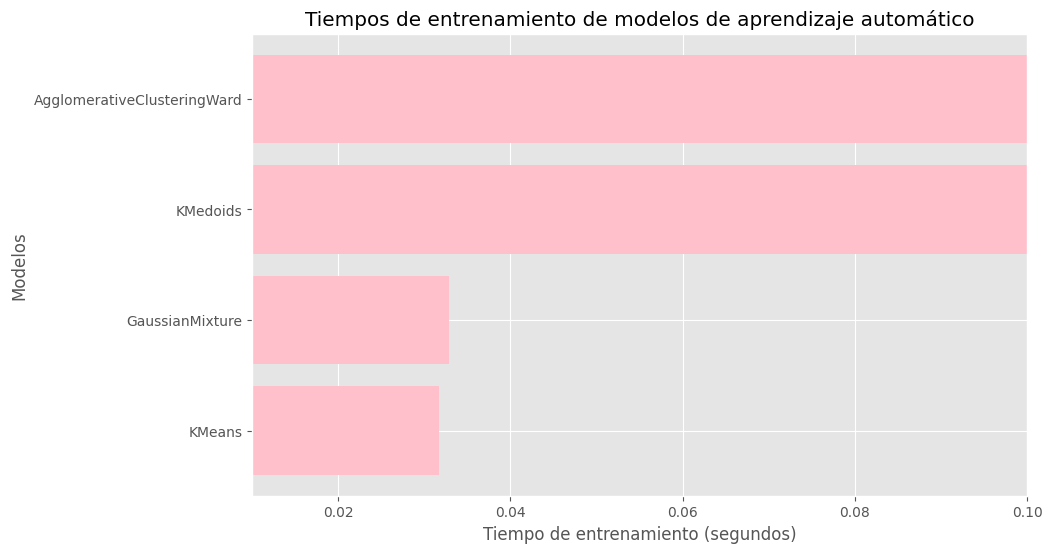

In [42]:
import matplotlib.pyplot as plt

# Datos de ejemplo
modelos = ["KMeans", "GaussianMixture", "KMedoids", "AgglomerativeClusteringWard"]
tiempos_entrenamiento = [total_time_KMeans_sklearn, tiempo_Gaussian, tiempo_KMedoids, tiempo_Agglomerative_ward]

# Crear el gráfico
plt.figure(figsize=(10, 6))  
plt.barh(modelos, tiempos_entrenamiento, color='pink')  
plt.xlabel('Tiempo de entrenamiento (segundos)') 
plt.ylabel('Modelos')  
plt.title('Tiempos de entrenamiento de modelos de aprendizaje automático')  

# Establecer el rango del eje x de 0.01 a 0.1
plt.xlim(0.01, 0.1)

plt.grid(True)  
plt.show()  


······························································································································································································································································
El mejor valor de silohoutte es con 6 componentes de KMeans. Pero como la diferencia entre Kmeans y el Gaussian Mixture model es mínima y Gaussian Mixture tiene un menor tiempo de ejecución es el que se utilizará para caracterizar estos seis grupos que nos han salido. Se ha usado boxplots de los datos y visto como se agrupa cada cluster y si se puede sacar alguna relación con la tabla de las estrellas. La tabla es la siguiente:
······························································································································································································································································

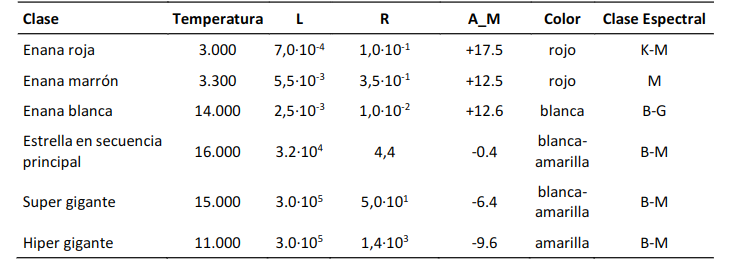

In [43]:
from IPython.display import display, Image

# Ruta de la imagen local
ruta_imagen = 'estrellas.png'

# Muestra la imagen
display(Image(filename=ruta_imagen))


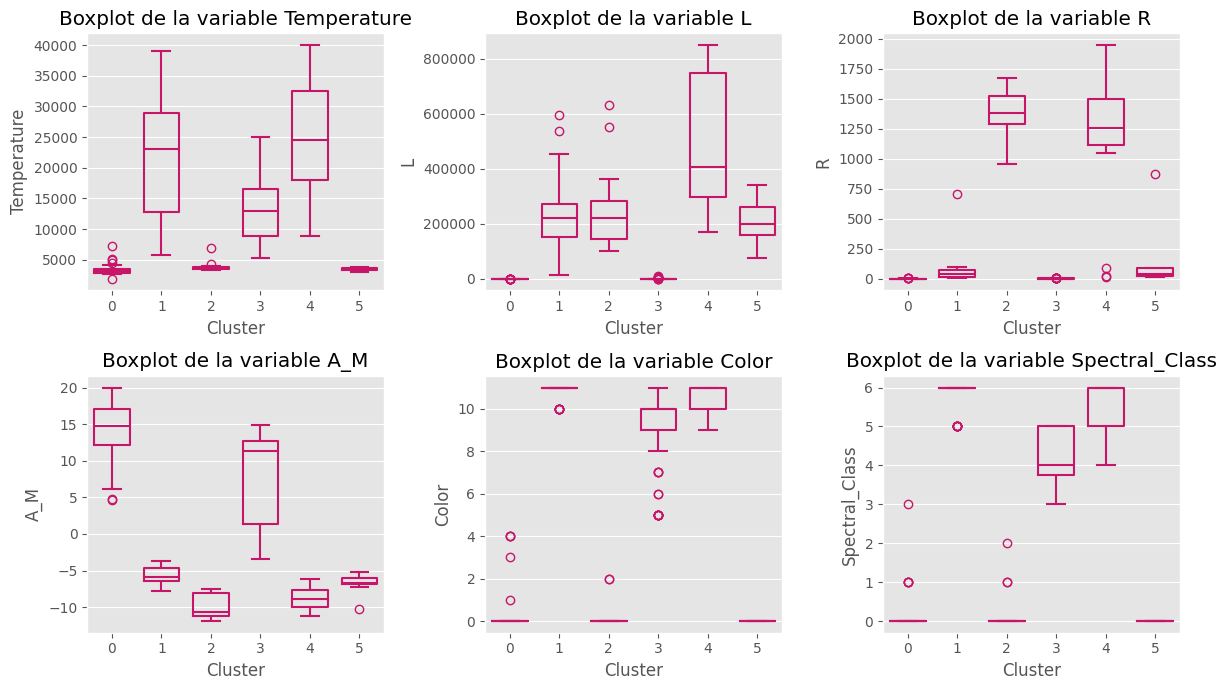

In [44]:

datos2 = corregido.copy()
y_predict_Kmeans = GaussianMixture(n_components=6, covariance_type='tied', random_state=23).fit_predict(X=X_trans)
datos2["Cluster"] = y_predict_Kmeans

aux = datos2.columns.tolist()
aux = aux[0:len(aux)-1]

fig, axes = plt.subplots(2, 3, figsize=(12, 7))
axes = axes.flatten()

for i, col in enumerate(aux):
    sns.boxplot(data=datos2, x="Cluster", y=col, ax=axes[i], fill=False, gap=.1, color='#C71569')
    axes[i].set_title(f"Boxplot de la variable {col}")

plt.tight_layout()
plt.show()


······························································································································································································································································
Esta es nuestra clasificación comparando con la tabla de estrellas:<br>

Cluster 0: Podría estar relacionado con una Enana Roja. Las enanas rojas suelen tener temperaturas bajas. Además, su color rojo y su clase espectral M también son indicativos de este tipo de estrellas. Tiene algún valor atípico con clase espectral mayor que M que podría ser ya que puede ser K/M. La luminosidad de este grupo es menor que cero, al igual que R y A_M se encuentra en 15, lo que cuadra perfectamente esta clase en general con una enana roja.<br>

Cluster 1: Este cluster podría estar relacionado con una Super Gigante. Estas estrellas suelen tener temperaturas muy altas y una luminosidad grande, que corresponde con los datos obtenidos. A_M es negativo, llegando a ser -6 tal ycomo la tabla, al igual que R que es unos 50(clavado). El color azul y la clase espectral O-B también son característicos de estas estrellas(no exacto pero tiene cierta relación).<br>

Cluster 2: Este cluster también podría estar relacionado con una Hiper Gigante. Aunque la temperatura es baja, tiene valores atípicos atemperaturas más altas, la luminosidad es muy alta, muy similar a la de la estrella super gigante al igual que en la tabla. El color rojo y la clase espectral de M a G(más o menos),también son indicativos de este tipo de estrellas. A_M y R de este cluster también son muy parecidos a los datos de la tabla con este tipo de estrella(-11 y 1400, en nuestro caso).<br>

Cluster 3: Este cluster podría estar relacionado con una Enana Blanca. Estas estrellas suelen tener temperaturas altas y una luminosidad y radio bajos(estas dos últimas no corrsponden muy bien a los datos de la tabla). El color blanco amarillento y la clase espectral F a B también son característicos de estas estrellas. También tiene un A_M bastante acertado con el de la tabla.<br>

Cluster 4: Este cluster podría estar relacionado con una Estrella en Secuencia. Estas estrellas suelen tener las temperaturas más altas y una luminosidad muy alta(la más alta en ambas en nuestro caso). El color azul-blanco y la clase espectral O a A también son indicativos de este tipo de estrellas. En R y en A_M da valores más bajos o más altos que la tabla, pero se mantiene concorde con cada característica aunque los valores no son los mismos.<br>

Cluster 5: Este cluster podría estar relacionado con una Enana marron. Las temperaturas son bajas y el color rojo y la clase espectral M, también son características en común con las de la tabla. Sin embargo, en este cluster la luminosidad, R y A_M, no son nada similares a los datos de la tabla, aun así, si que mantiene cierta relación ya que en luminosidad es la tercera más baja, en R sigue siendo unas de las más baja aunque no corresponda exactamente. <br>
······························································································································································································································································


----------------------------------------------------------------------------------------------------------------
## PCA CON 3 DIMENSIONES
----------------------------------------------------------------------------------------------------------------

······························································································································································································································································
Vamos a realizar el PCA con 3 dimensiones para determinar si es mejor dos componentes o tres, en función de los diferentes resultados y la interpretación de los resultados. En caso de que representa mayor variabilidad(no siendo esta el 100%), nos decantaremos lo más probable por dos dimensiones para poder ver e interpretar mejor las agrupaciones que se hacen.
······························································································································································································································································

In [45]:
X3 = datos_scaled_df.values

# PCA con 2 componentes principales
pca3 = PCA(n_components=3)

# Ajustar y transformar los datos
X_trans3 = pca3.fit_transform(X3)

# Crear un DataFrame con los componentes principales
df_pca3 = pd.DataFrame(X_trans3, columns=['PC1','PC2','PC3'])
df_pca3.head()

,PC1,PC2,PC3
0,-2.067808,-0.147152,0.190962
1,-2.087328,-0.165090,0.195077
2,-2.188924,-0.236104,0.217676
3,-2.101169,-0.161525,0.198859
4,-2.273203,-0.273557,0.237536


In [46]:
std = df_pca3.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca3.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca3.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.55409866 0.29691252 0.06395951]
Proporción acumulada: [0.55409866 0.85101118 0.91497069]


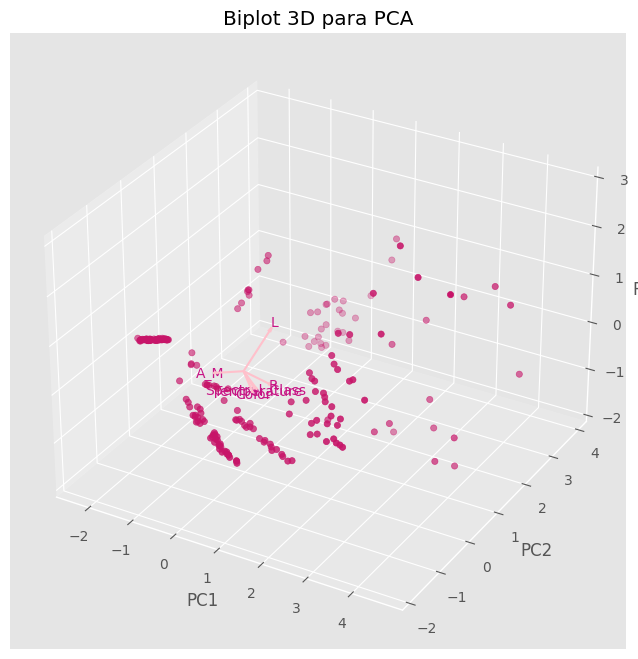

In [47]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

def biplot_3d(scaled_data, fitted_pca, original_dim_labels):
    pca_results = fitted_pca.transform(scaled_data)

    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    pca1_scores = pca_results[:, 0]
    pca2_scores = pca_results[:, 1]
    pca3_scores = pca_results[:, 2]

    # Plot each point in 3D post-PCA space
    ax.scatter(pca1_scores, pca2_scores, pca3_scores, color='#C71569')

    # Label each point
    for i in range(len(pca1_scores)):
        ax.text(pca1_scores[i], pca2_scores[i], pca3_scores[i], '')

    # For each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0, i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1, i]
        raw_dims_delta_on_pca3 = fitted_pca.components_[2, i]
        ax.quiver(0, 0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2, raw_dims_delta_on_pca3,
                  color='pink', arrow_length_ratio=0.1)
        ax.text(raw_dims_delta_on_pca1*1.1, raw_dims_delta_on_pca2*1.1, raw_dims_delta_on_pca3*1.1,
                original_dim_labels[i], color='#C71585', ha='center', va='center')

    ax.set_xlabel("PC{}".format(1))
    ax.set_ylabel("PC{}".format(2))
    ax.set_zlabel("PC{}".format(3))
    ax.set_title("Biplot 3D para PCA")
    plt.show()

# Llama a la función biplot_3d con tus datos y modelos PCA
biplot_3d(datos_scaled, pca3, original_dim_labels=data_set.columns)


······························································································································································································································································
Podemos observar que al usar tres dimensiones cuesta ver las correlaciones aunque se puede notar que color, spectral_class y temperatura están correladas, sin embargo los angulos no se aprecian muy bien, por lo que las correlaciones entre A_M, L y R están más difíciles de interpretar que en la gráfica de dos dimensiones.
······························································································································································································································································

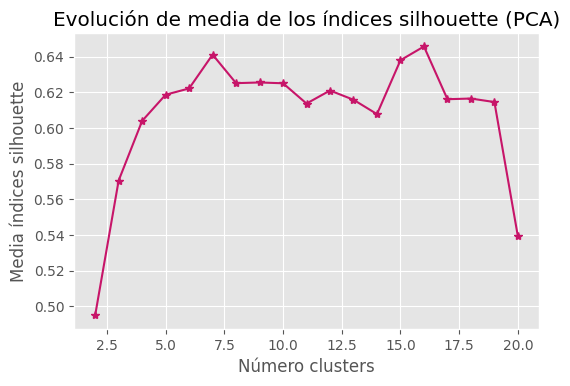

In [48]:

from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 21)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeans_sklearn(
        n_clusters=n_clusters,
        n_init=25, 
        random_state=23

    )
    modelo_kmeans.fit(X=X_trans3) 
    cluster_labels = modelo_kmeans.predict(X=X_trans3)
    silhouette_avg = silhouette_score(X_trans3, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.show()


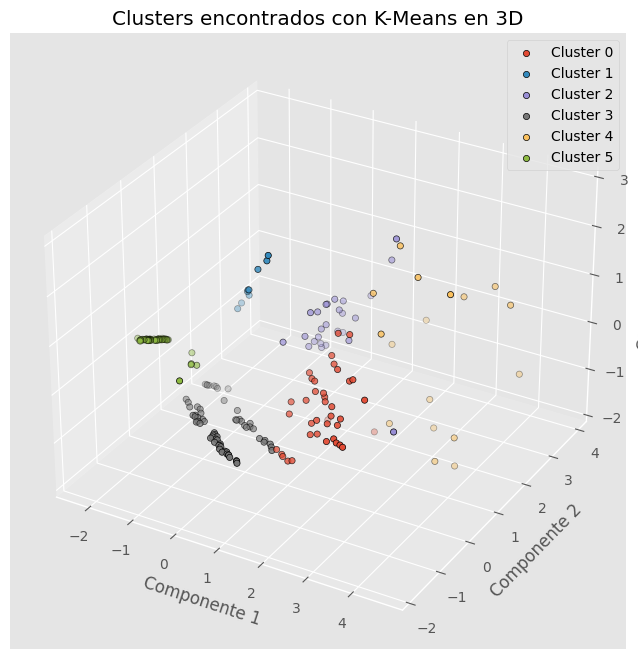

In [49]:
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns

# Crear la figura y los ejes 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=6).fit(X=X_trans3)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans3)

# Paleta de colores personalizada


# Dibujar cada punto en el gráfico 3D
for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        xs=X_trans3[y_predict_Kmeans == i, 0],
        ys=X_trans3[y_predict_Kmeans == i, 1],
        zs=X_trans3[y_predict_Kmeans == i, 2], 
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )

ax.set_title('Clusters encontrados con K-Means en 3D')
ax.set_xlabel('Componente 1')
ax.set_ylabel('Componente 2')
ax.set_zlabel('Componente 3')
ax.legend()

plt.show()


······························································································································································································································································
En este grafico podemos ver que es dificil de diferenciar bien las clases por las dimensiones en la que está la gráfica, debido a que por ejemplo el color gris (cluster 3) con el verde se mezclan los puntos y no se puede ver exactamente donde estan situados cada punto con total claridad, y mezcla las distintas agrupaciones. Por ellos como un 0,85 de variabilidad es bastante bueno no seguiremos con tres dimensiones ya que es mejor poder ver con claridad como clasifica los puntos a no poder representarlo y verlo de manera correcta como en esta situación.
······························································································································································································································································

----------------------------------------------------------------------------------------------------------------
## ONE HOT ENCODING
----------------------------------------------------------------------------------------------------------------

······························································································································································································································································
Vamos a probar nuestros datos pero haciendo la transformación de los ordinales con one-hot-encoding. Se transformaran tanto los colores como la clase espectral. Se realizará mismo procedimiento de PCA y se implementará el modelo KMeans.
······························································································································································································································································

······························································································································································································································································
1. Transformamos datos con one-hot-encoding.
······························································································································································································································································

In [50]:
# Define el orden de los colores
corregido2 = pd.read_csv('Stars2.csv')
print("Dimensiones de corregido antes de la corrección del color:", corregido2.shape)
color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']

# Encuentra los valores únicos en la columna "Color.
unique_colors = set(corregido2['Color'])

# Encuentra los valores de la columna "Color" que no están en color_order.
missing_colors = unique_colors - set(color_order)

# Imprime los valores que faltan
print("Valores de la columna Color que no están en color_order:")
for color in missing_colors:
    print(color)

# Define el diccionario de mapeo para corregir los valores incorrectos.
correction_mapping = {
    'Blue white': 'Blue-white',
    'Blue White': 'Blue-white',
    'Blue-White': 'Blue-white',
    'white': 'White',
    'yellowish': 'Yellowish'
}

# Reemplaza los valores incorrectos en la columna "Color".
corregido2['Color'] = corregido2['Color'].replace(correction_mapping)

color_order = ['Red', 'Orange-Red', 'Orange', 'Pale yellow orange', 'Yellowish', 
               'yellow-white', 'Whitish', 'Yellowish White', 'White-Yellow', 'White', 
               'Blue-white', 'Blue']



Dimensiones de corregido antes de la corrección del color: (240, 6)
Valores de la columna Color que no están en color_order:
white
Blue white
yellowish
Blue-White
Blue White


······························································································································································································································································
Realizamos pca para crear dos componentes sobre los datos y poder ver las agrupaciones en dos dimensiones.
······························································································································································································································································

In [51]:
# Define una columna categórica para el color según el orden definido
corregido2['Color'] = pd.Categorical(corregido2['Color'], categories=color_order, ordered=True)

# Crea el one-hot encoding para la columna "Color"
color_onehot = pd.get_dummies(corregido2['Color'], prefix='Color')

# Define una columna categórica para la clase espectral según el orden definido
corregido2['Spectral_Class'] = pd.Categorical(corregido2['Spectral_Class'], categories=spectral_class_order, ordered=True)

# Crea el one-hot encoding para la columna "Spectral_Class"
spectral_onehot = pd.get_dummies(corregido2['Spectral_Class'], prefix='Spectral_Class')

# Combina ambos one-hot encodings con el DataFrame original
corregido2_encoded = pd.concat([corregido2.drop(['Color', 'Spectral_Class'], axis=1), color_onehot, spectral_onehot], axis=1)

# Aplica PCA a los datos con ambos one-hot encodings
X2 = corregido2_encoded.values  # Obtener los valores de los datos

# Escalado de las variables
# ==============================================================================
datos_scaled2 = scale(corregido2_encoded, axis=0, with_mean=True, with_std=True)
datos_scaled2_df = pd.DataFrame(datos_scaled2, columns=corregido2_encoded.columns, index=corregido2_encoded.index)
datos_scaled2_df.head(4)

X = datos_scaled2_df.values

# PCA con 2 componentes principales
pca2 = PCA(n_components=2)

# Ajustar y transformar los datos
X_trans2 = pca2.fit_transform(X)

# Crear un DataFrame con los componentes principales
df_pca2 = pd.DataFrame(X_trans2, columns=['PC1','PC2'])
df_pca2.head()



,PC1,PC2
0,-2.273213,0.366309
1,-2.288704,0.354942
2,-2.370935,0.307271
3,-2.300858,0.355257
4,-2.440693,0.278760


In [52]:
std = df_pca2.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca2.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca2.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.18611084 0.1158609 ]
Proporción acumulada: [0.18611084 0.30197174]


In [53]:
# PCA con 2 componentes principales
pca2_3 = PCA(n_components=3)

# Ajustar y transformar los datos
X_trans2_3= pca2_3.fit_transform(X)

# Crear un DataFrame con los componentes principales
df_pca2_3 = pd.DataFrame(X_trans2_3, columns=['PC1','PC2', 'PC3'])
df_pca2_3.head()

,PC1,PC2,PC3
0,-2.273213,0.366309,-0.206187
1,-2.288704,0.354942,-0.206844
2,-2.370935,0.307271,-0.206844
3,-2.300858,0.355257,-0.204817
4,-2.440693,0.278760,-0.203562


In [54]:
std = df_pca2_3.describe().transpose()["std"]
print(f"Proporción de varianza explicada: {pca2_3.explained_variance_ratio_}")
print(f"Proporción acumulada: {np.cumsum(pca2_3.explained_variance_ratio_)}")

Proporción de varianza explicada: [0.18611084 0.1158609  0.08922737]
Proporción acumulada: [0.18611084 0.30197174 0.39119911]


·····························································································································································································································································
La variabilidad para 3 dimensiones, es decir, tres componentes también sigue reflejando muy poca variabilidad de los datos y ninguna de las dos transformaciones son útiles.
·····························································································································································································································································

·····························································································································································································································································
Como se puede ver, los datos transformados con one-hot-encoding solo representan un 0.3... de variabilidad, lo que significa que estas componentes creadas no capturan una gran parte de la variabilidad en los datos originales. Por lo que los resultados no serán muy importantes para nuestros datos porque representan muy poca parte de ellos.
·····························································································································································································································································

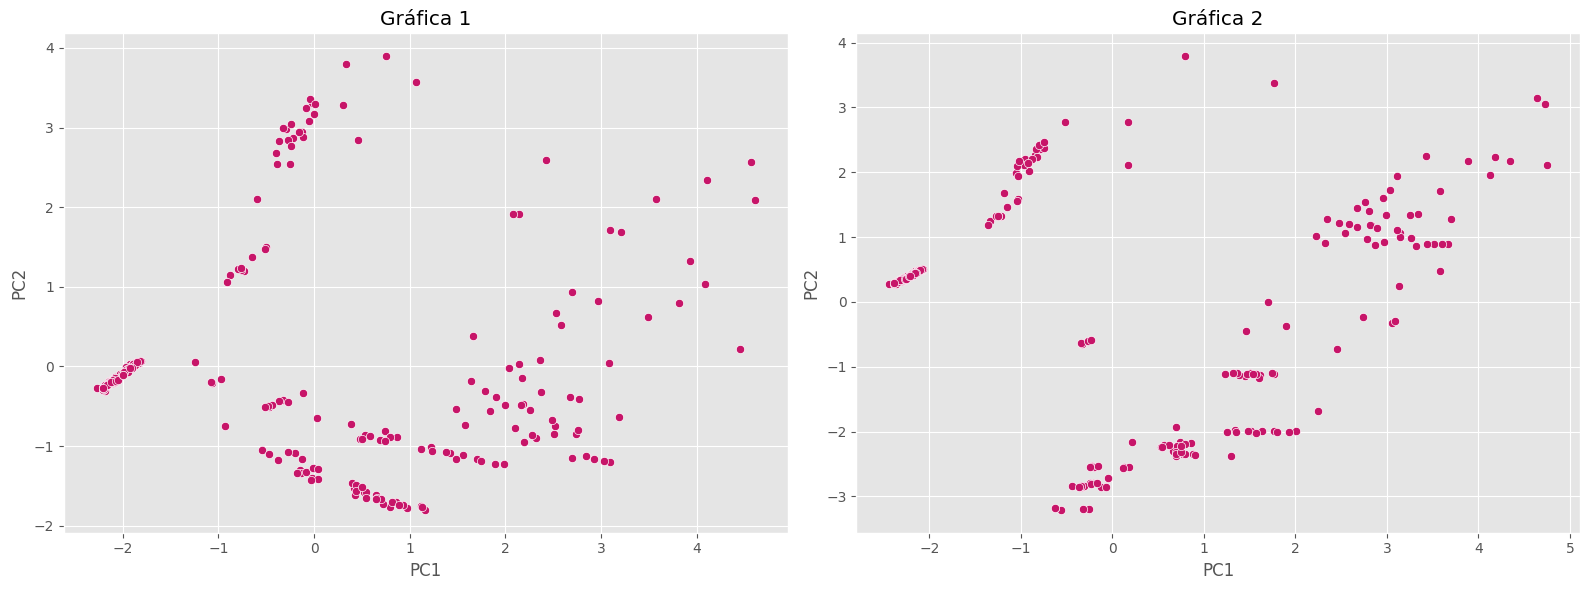

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Primera gráfica
axes[0].set_title('Gráfica 1')
sns.scatterplot(data=df_pca, x="PC1", y="PC2", color='#C71569', ax=axes[0])

# Segunda gráfica
axes[1].set_title('Gráfica 2')
sns.scatterplot(data=df_pca2, x="PC1", y="PC2", color='#C71569', ax=axes[1])

plt.tight_layout()
plt.show()

······························································································································································································································································
Como se puede ver el 0.3 de representación de la variabilidad que es el caso de la derecha no refleja correctamente los puntos más bajos de esta grafica comparandola con la de la izquierda que representa un 85% de variabilidad de los datos. Por lo que utilizar la transformación de one-hot-encoding no representa correctamente el problema planteado.
······························································································································································································································································

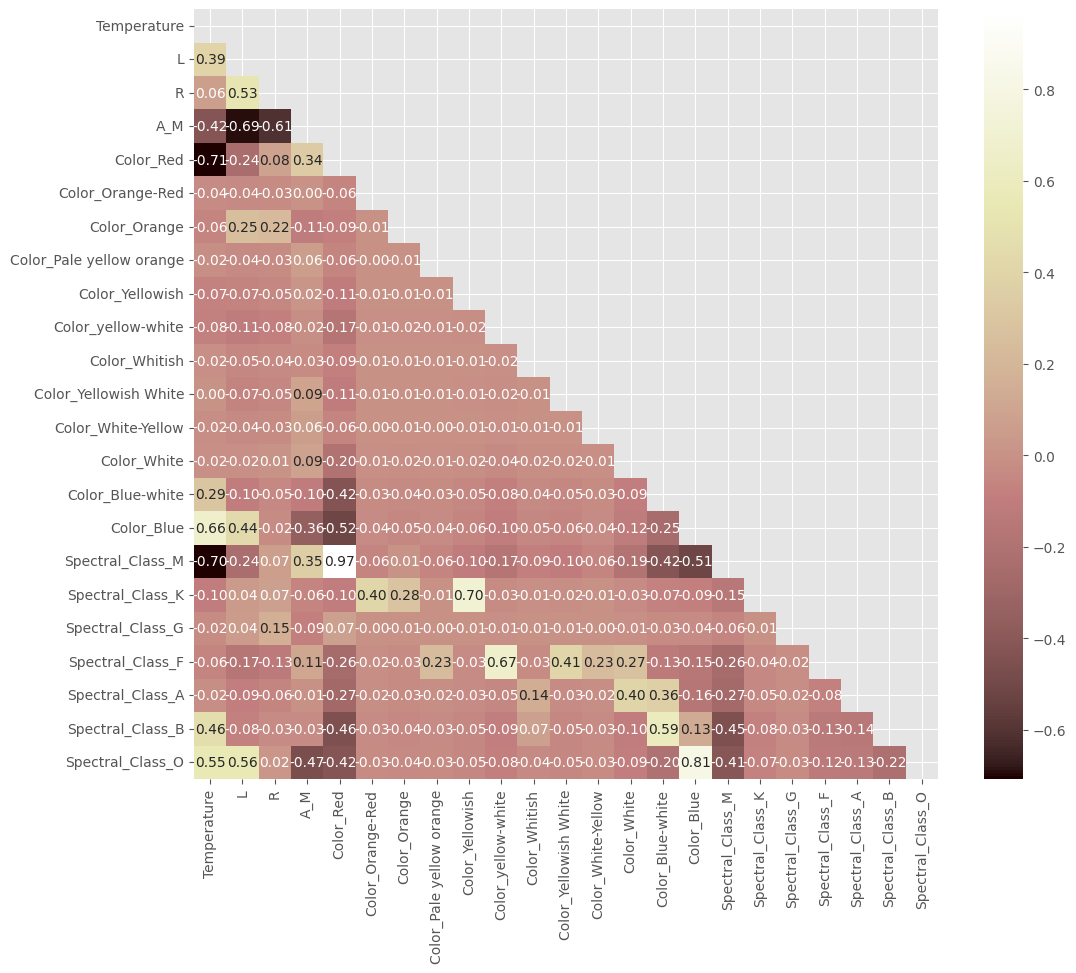

In [56]:
# Obtener la matriz de correlación
corr_df = corregido2_encoded.corr()
etiquetas = corr_df.columns
mask_ut = np.triu(np.ones(corr_df.shape)).astype(bool)

# Crear el mapa de calor con un tamaño de figura más grande y números más grandes
plt.figure(figsize=(12, 10))  # Ajusta el tamaño de la figura según tus preferencias
sns.heatmap(corr_df, mask=mask_ut, annot=True, cmap="pink", fmt=".2f", annot_kws={"size": 10})  # Ajusta el tamaño de la fuente según tus preferencias
plt.show()


·····························································································································································································································································
A_M, L y R es la misma correlación que sin la transformación de one-hot-encoding debido a que estas variables no han sido transformadas. SIn embargo, los colores y las clases espectrales no se puede apreciar bien la correlación que deberían de tener. Las que tienen más apariciones en los datos como son M y O o rojo y azul si que están correladas con su significado y temperatura pero el resto de colores no s erefelejan correctamente.
·····························································································································································································································································

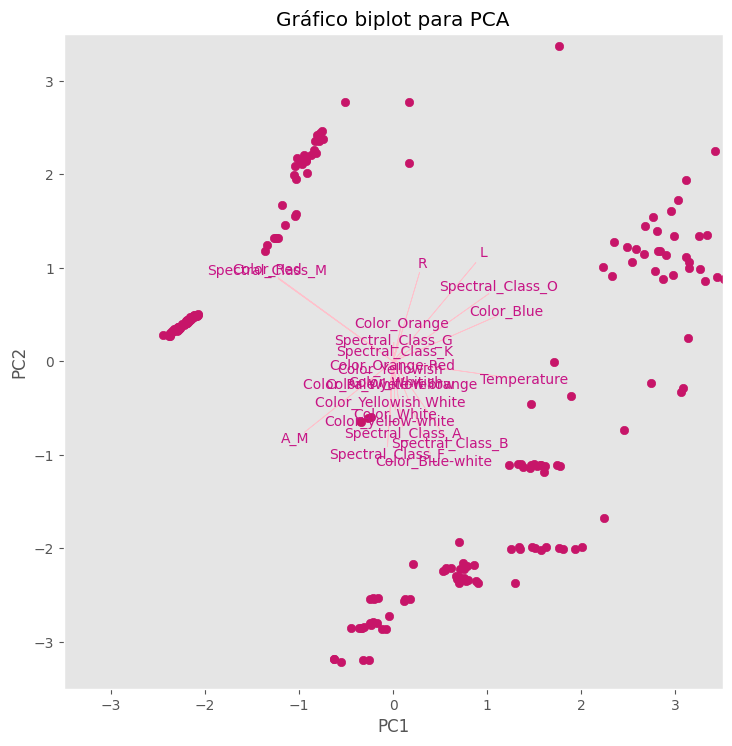

In [57]:
import numpy as np

def biplot(scaled_data, fitted_pca, original_dim_labels):

    pca_results = fitted_pca.transform(scaled_data)
    pca1_scores = pca_results[:, 0]
    pca2_scores = pca_results[:, 1]

    # plot each point in 2D post-PCA space
    plt.scatter(pca1_scores, pca2_scores, color='#C71569')

    # label each point
    for i in range(len(pca1_scores)):
        plt.text(pca1_scores[i], pca2_scores[i], '') 

    # for each original dimension, plot what an increase of 1 in that dimension means in this space
    for i in range(fitted_pca.components_.shape[1]):
        raw_dims_delta_on_pca1 = fitted_pca.components_[0, i]
        raw_dims_delta_on_pca2 = fitted_pca.components_[1, i]
        
        # Scale the vectors
        scale_factor = 3  # Adjust this factor for longer lines
        raw_dims_delta_on_pca1 *= scale_factor
        raw_dims_delta_on_pca2 *= scale_factor
        
        plt.arrow(0, 0, raw_dims_delta_on_pca1, raw_dims_delta_on_pca2, color='pink', alpha=1)
        text_offset = 0.1  # Offset for text labels
        plt.text(raw_dims_delta_on_pca1 * (1 + text_offset), raw_dims_delta_on_pca2 * (1 + text_offset),
                 original_dim_labels[i], color='#C71585', ha='center', va='center')

plt.figure(figsize=(8.5, 8.5))
plt.xlim(-3.5, 3.5)
plt.ylim(-3.5, 3.5)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.title("Gráfico biplot para PCA")
plt.grid()
biplot(datos_scaled2, pca2.fit(datos_scaled2), original_dim_labels=corregido2_encoded.columns)

·····························································································································································································································································
Podemos determinar que la codificación One-Hot-Encoding es bastante mala, puesto que al observar este biplot vemos que es bastante difícil de interpretar y los puntos generados no representan bien las agrupaciones. 
·····························································································································································································································································

·····························································································································································································································································
Vamos a comprobar con la métrica silohoutte el mejor número de clusters para este modelo y ejemplo.
·····························································································································································································································································

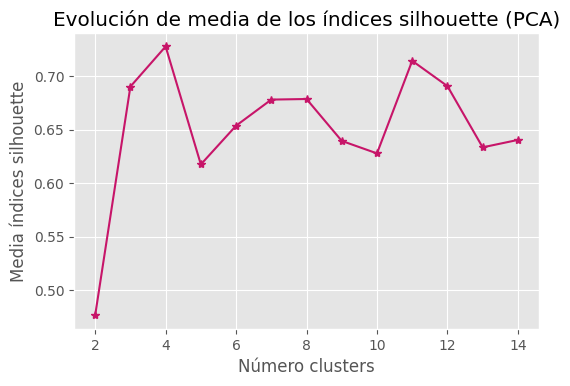

In [58]:

from sklearn.metrics import silhouette_score

range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo_kmeans = KMeansP(
        n_clusters=n_clusters
    )
    modelo_kmeans.fit(X=X_trans2) 
    cluster_labels = modelo_kmeans.predict(X=X_trans2)
    silhouette_avg = silhouette_score(X_trans2, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

# Plot
plt.figure(figsize=(6, 3.84))
plt.plot(range_n_clusters, valores_medios_silhouette, marker='*', color='#C71569')
plt.title("Evolución de media de los índices silhouette (PCA)")
plt.xlabel('Número clusters')
plt.ylabel('Media índices silhouette')
plt.show()


·····························································································································································································································································
Lo probamos con K=4. Se puede ver que el mejor valor obtenido es 0,7 pero aunque sea un muy buen valor de este coeficiente al no representar los datos y tener una variabilidad de 0.3 los resultados no son muy utiles para esta práctica.
·····························································································································································································································································

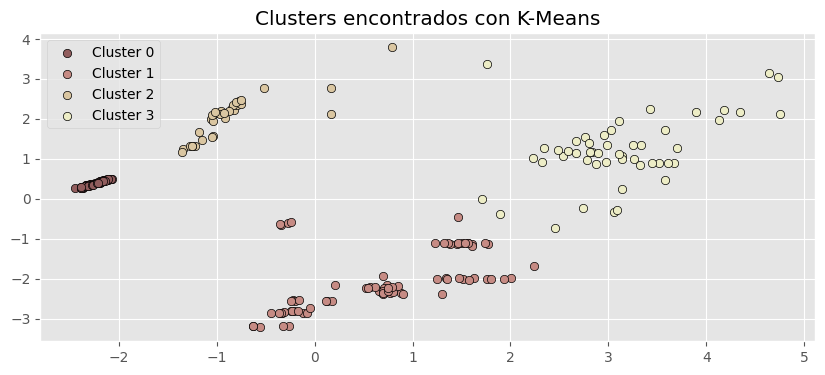

In [59]:
# Definir una paleta de colores personalizada en tonos de rosa
custom_palette = sns.color_palette("pink", 4)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))

# Clustering con tu KMeans personalizado
modelo_kmeans = KMeansP(n_clusters=4).fit(X=X_trans2)
y_predict_Kmeans = modelo_kmeans.predict(X=X_trans2)

for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans2[y_predict_Kmeans == i, 0],
        y=X_trans2[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

#Mostrar la gráfica.
plt.show()


·····························································································································································································································································
Vamos a dibujar los boxplot, aunque este caso no representa correctamente la variabilidad de nuestros datos, por lo que es simplemnte para ver la clasificación y reafirmar todo lo anterior.
·····························································································································································································································································

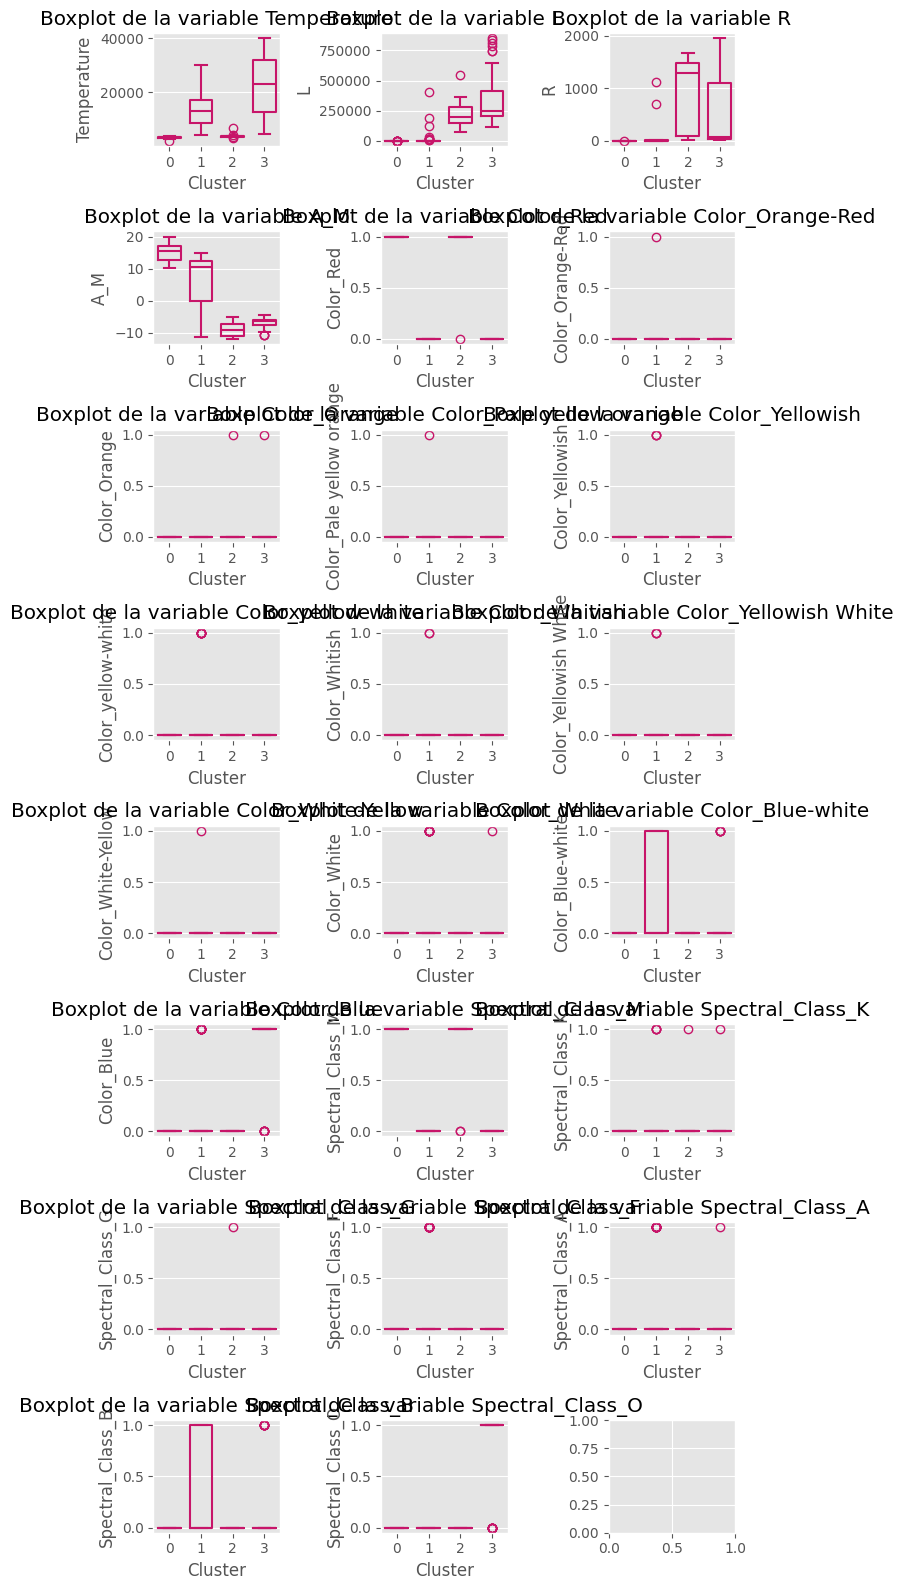

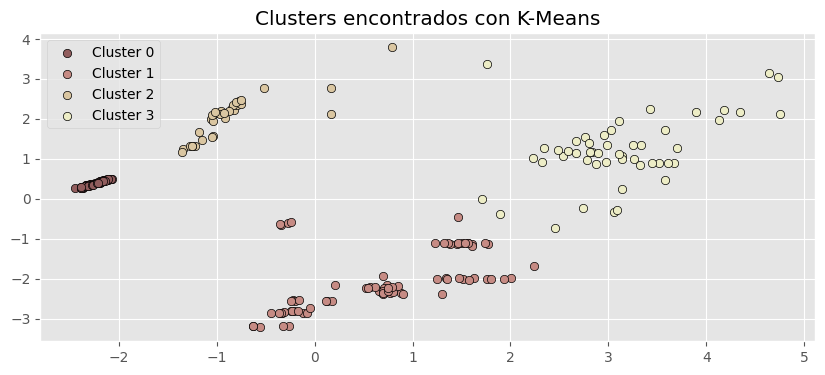

In [60]:
datos2 = corregido2_encoded.copy()
datos2["Cluster"] = y_predict_Kmeans

# Obtener una lista de todas las columnas excepto la última (la de "Cluster")
columnas = datos2.columns[:-1]


fig, axes = plt.subplots(8, 3, figsize=(7, 16))
axes = axes.flatten()

# Iterar sobre las columnas y dibujar los boxplots en la matriz de gráficos
for i, col in enumerate(columnas):
    sns.boxplot(data=datos2, x="Cluster", y=col, ax=axes[i], fill=False, gap=.1, color="#C71569")
    axes[i].set_title(f"Boxplot de la variable {col}")

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout()
plt.show()

# Definir una paleta de colores personalizada en tonos de rosa
custom_palette = sns.color_palette("pink", 4)

# Crear la figura y los ejes
fig, ax = plt.subplots(1, figsize=(10, 4))
# Graficar los puntos en el espacio PCA coloreados por el cluster 
for i in np.unique(y_predict_Kmeans):
    ax.scatter(
        x=X_trans2[y_predict_Kmeans == i, 0],
        y=X_trans2[y_predict_Kmeans == i, 1],
        c=custom_palette[i],
        marker='o',
        edgecolor='black',
        label=f"Cluster {i}"
    )
ax.set_title('Clusters encontrados con K-Means')
ax.legend()

# Mostrar la gráfica
plt.show()


·····························································································································································································································································
Con one-hot-encoding, no se muestra ninguna información relevante de los datos. Los colores y las clases espectrales se convierten en características binarias independientes, lo que significa que no muestran ninguna distribución al ser true o false en las instancias. Además, dado que el one-hot encoding no conserva ningún orden de relevancia entre las categorías, se pierde la información importante de que el rojo indica una temperatura baja y el azul indica una temperatura alta. Por lo tanto, estas características codificadas de esta manera no aportan el tipo de información que podría ser relevante para nuestro análisis. Por lo que puede dar un mejor resultado de silohoutte pero no profundiza ni representa correctamente los datos.
·····························································································································································································································································

-----------------------------------------------------------------------------------------------------------------------
## CONCLUSIÓN
-----------------------------------------------------------------------------------------------------------------------

·····························································································································································································································································
Esta práctica nos ha ayudado a aprender a utilizar diferentes modelos de aprendizaje autómatico no supervisado mediante los cuales hemos sido capaces evaluar los datos dados y extraer información relevante para poder relacionar los distintos tipos de estrellas con los resultados obtenidos. Hemos podido comprobar que hay que prestar especial atención a los datos categóricos ordinales, y decidir correctamente el método de transformación, ya que métodos de transformación como One-Hot-Encoding no tiene en cuenta si la variable categórica tiene un orden que influirá en las sgrupaciones. Es primordial, saber hacer esta distinción para la hora de transformar los atributos no cometer errores. También se ha podido comprobar que si la variabilidad de los datos es lo suficientemente buena(mayor que 0,8), se puede llegar a preferir un modelo de dos dimensiones ya que se entiende, se representa  y se interpreta mejor que uno de tres. Nos ha resultado bastante interesante poder realizar una práctica con datos reales y poder ver como las conclusiones que hemos extraído de nuestro trabajo mantiene cierta relación a los datos reales y clasificaciones llevadas a cabo por científicos y poder hacerlas nosotras mismas, con los diferentes modelos implementados. 
·····························································································································································································································································